# VAR Estimation and Impulse Response Analysis Using Segmented Sleeping Giants Data

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

### Level of Aggregation Selector
`STEP_SIZE` sets the global level of aggregation for the analysis.

In [31]:
FILE_STEP_SIZE = '12h'
WINDOW_SIZE = 90
WINDOW_STEP_SIZE = 30
MODEL_STEP_SIZE = '12h'
pd.options.display.max_columns = 50

In [32]:
sg_timeline = pd.read_csv(f"FE_data_TimeOfDay{FILE_STEP_SIZE}_WeightedActions_gt_bb.csv")
sg_timeline["date_time"] = pd.to_datetime(sg_timeline.date_time)
sg_tl_only = sg_timeline[["date_time", 
                          "Motivational Frame", 
                          "Diagnostic Frame", 
                          "Prognostic Frame",
                          "msnbc_bb_mentions", 
                          "Fox"]].groupby(pd.Grouper(key='date_time', freq=MODEL_STEP_SIZE)).first()
sg_participants = sg_timeline[["date_time", 
                               "sig_i_bb_related_indv_t", 
                               "sig_i_act_indv_t"]].groupby(pd.Grouper(key='date_time',
                                                                        freq=MODEL_STEP_SIZE)).first().reset_index()
sg_ts = sg_participants.merge(sg_tl_only, on="date_time", how="inner").fillna(0)
sg_ts.set_index("date_time", inplace=True)

In [ ]:
"""sg_desc = sg_ts.reset_index()
sg_desc_ranged = sg_desc.loc[(sg_desc['date_time'] >= datetime.datetime(2016,11,1,0,0,0)) & (sg_desc['date_time'] <= datetime.datetime(2017,10,27,0,0,0))]
sg_desc_ranged.describe().T.to_csv("./ranged_descriptives.csv", index=True)"""

Text(0.5, 0.01, 'Periods')

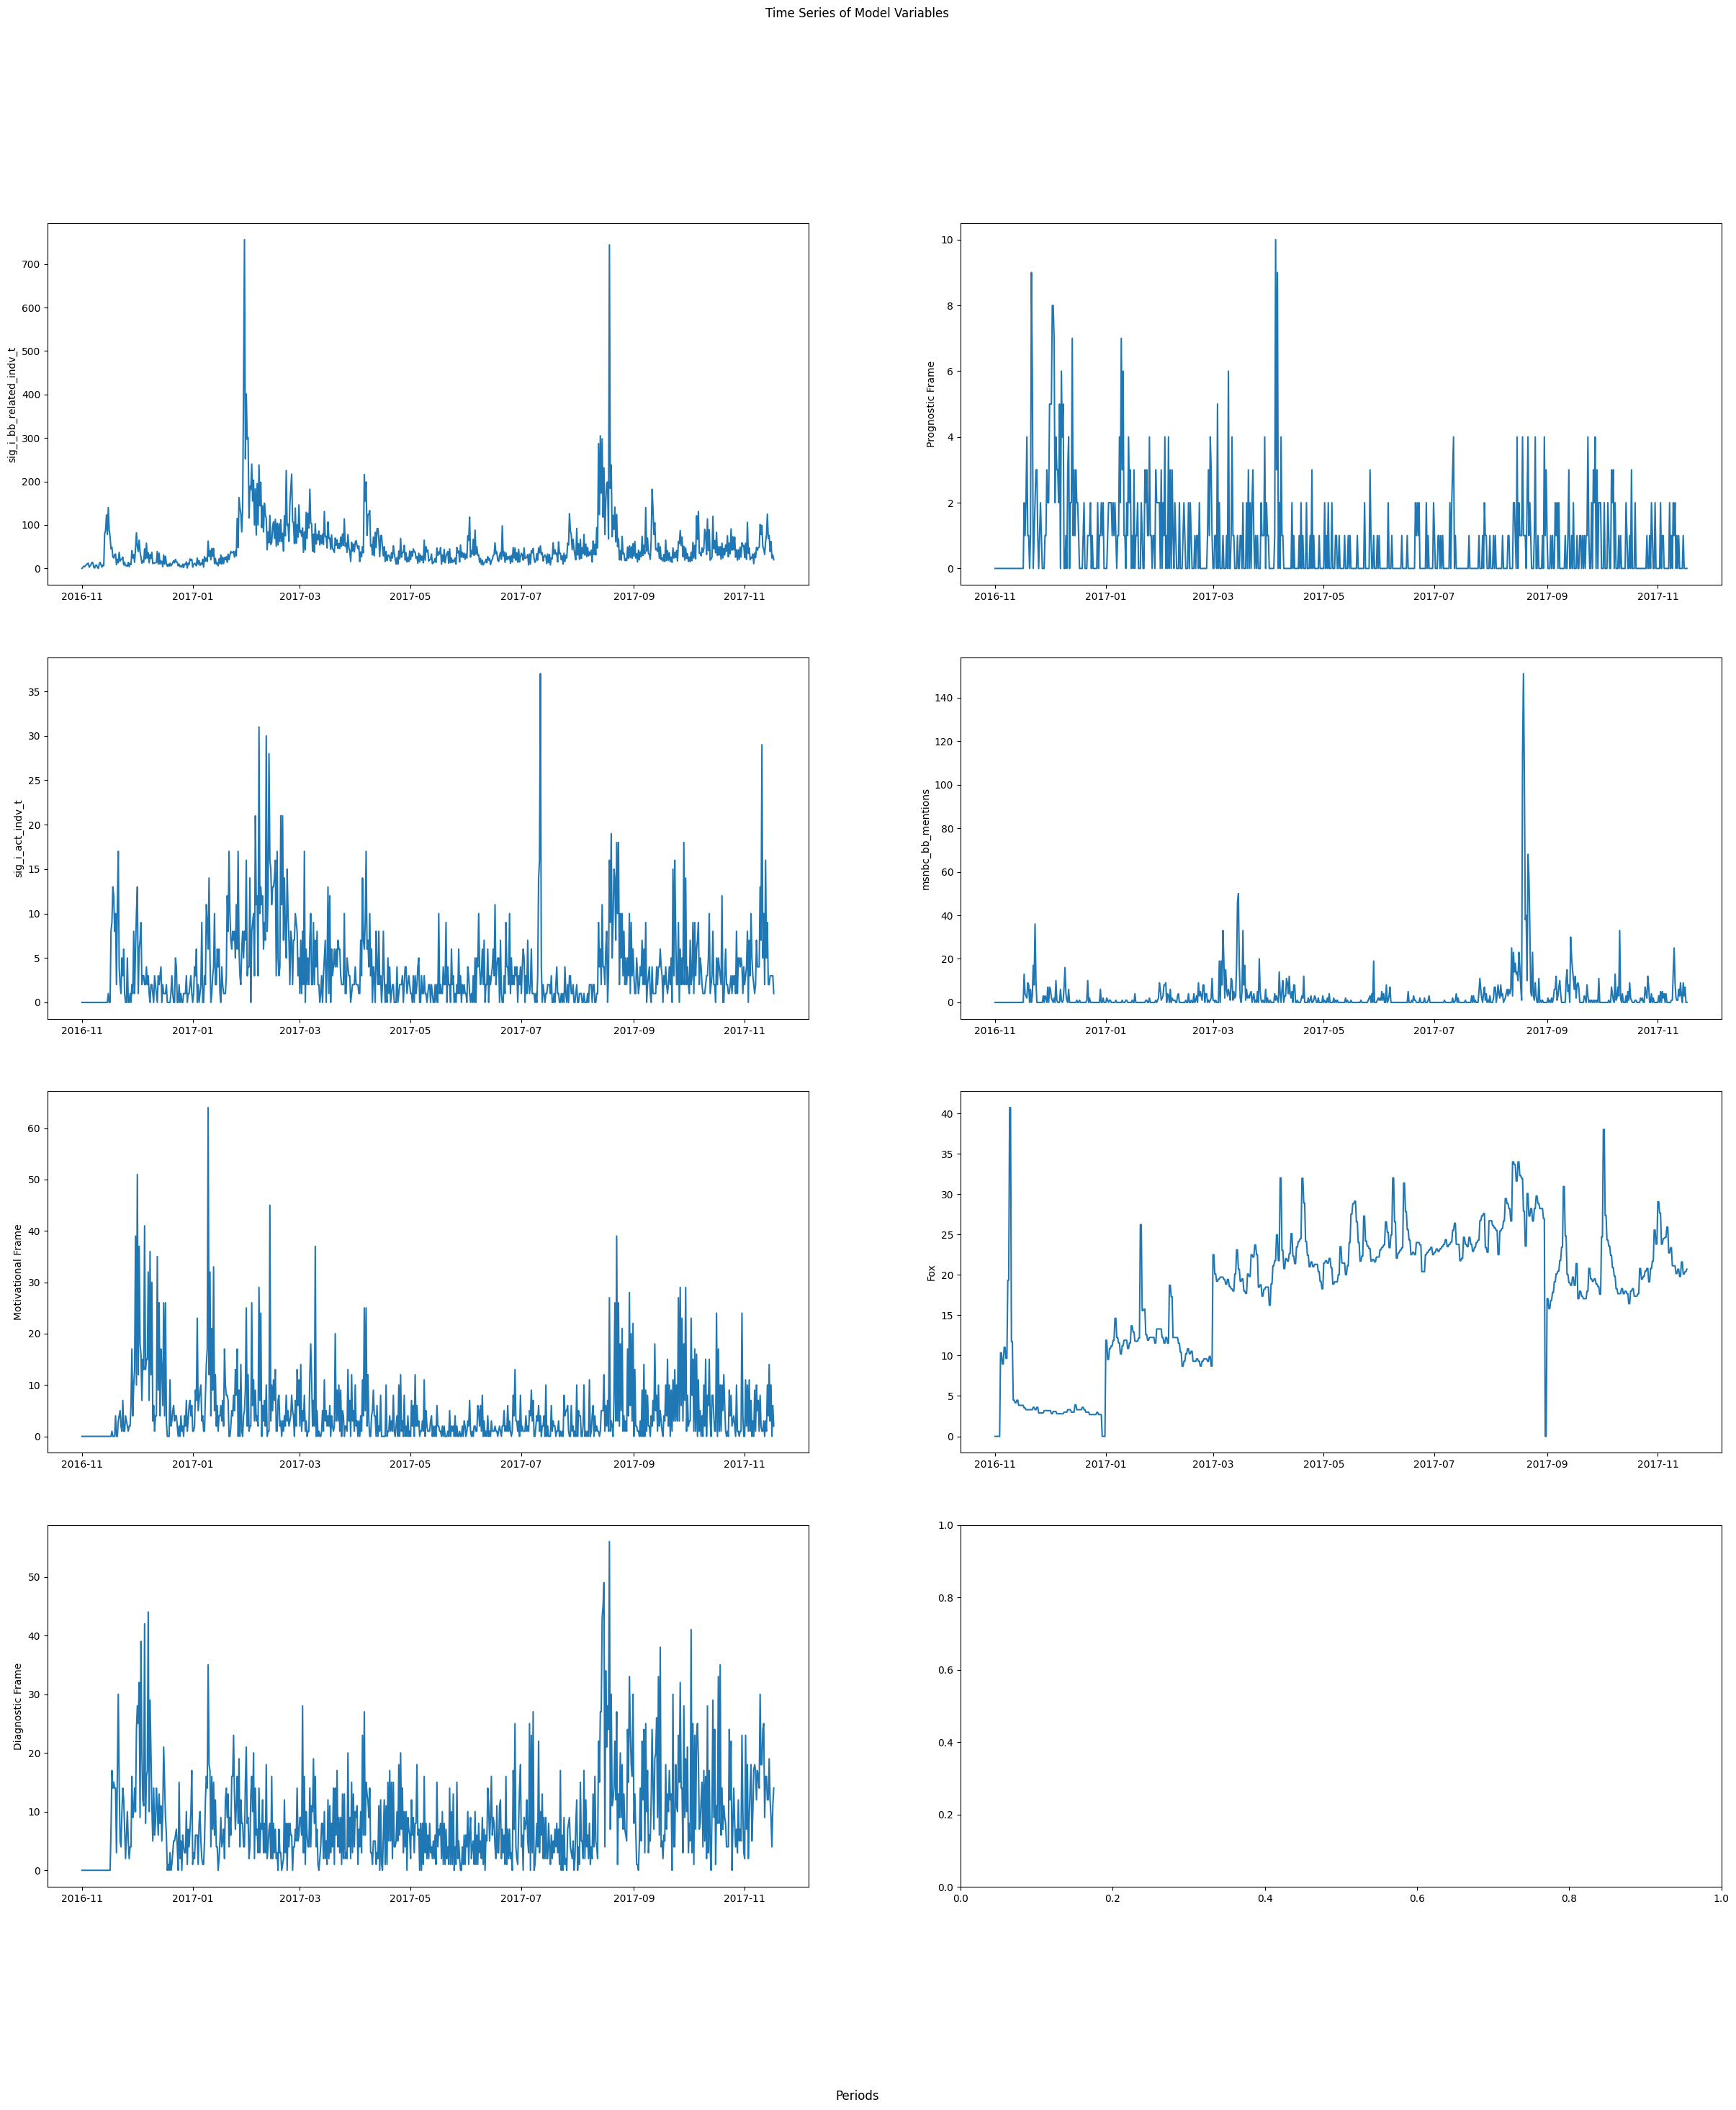

In [33]:
vars = ["sig_i_bb_related_indv_t", "sig_i_act_indv_t", "Motivational Frame", "Diagnostic Frame", "Prognostic Frame","msnbc_bb_mentions", "Fox"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30,30))
var_num = 0
for i in range(2):
    for r in range(4):
        if var_num < len(vars):
            var = vars[var_num]
            ax = axes[r][i] 
            ax.plot(sg_ts[var])
            ax.set_ylabel(var)
            var_num += 1

fig.suptitle(f"Time Series of Model Variables")
fig.supxlabel("Periods")

# Create Time of Day `tod` Control, Enumerate Available Series

**Available series:**

```python
['sig_i_con_indv_t', 'sig_i_act_indv_t', 'sig_i_bb_related_indv_t',
'sig_i_con_indv_t_retweets', 'sig_i_con_indv_t_likes',
'sig_i_con_indv_t_replies', 'sig_i_act_indv_t_retweets',
'sig_i_act_indv_t_likes', 'sig_i_act_indv_t_replies', 'retweets',
'favorites', 'replies', 'Diagnostic Frame', 'Prognostic Frame',
'Motivational Frame', 'msnbc_bb_mentions', 'sg_bb_mentions',
'Diagnostic_Frame_retweets', 'Motivational_Frame_retweets',
'Prognostic_Frame_retweets', 'Diagnostic_Frame_likes',
'Motivational_Frame_likes', 'Prognostic_Frame_likes',
'Diagnostic_Frame_replies', 'Motivational_Frame_replies',
'Prognostic_Frame_replies', '
'cnn_bb_mentions', 'fox_bb_mentions', 'Fox',
'FOX NEWS', 'DiagXMsnbc']
```

In [34]:
# Create time of day control
print(sg_ts.columns)
sg_ts["tod"] = 0 # 0=>AM 1=>PM
sg_ts.loc[sg_ts.index.time == datetime.time(12,0), 'tod'] = 1
sg_ts["tod"]

Index(['sig_i_bb_related_indv_t', 'sig_i_act_indv_t', 'Motivational Frame',
       'Diagnostic Frame', 'Prognostic Frame', 'msnbc_bb_mentions', 'Fox'],
      dtype='object')


date_time
2016-11-01 00:00:00    0
2016-11-01 12:00:00    1
2016-11-02 00:00:00    0
2016-11-02 12:00:00    1
2016-11-03 00:00:00    0
                      ..
2017-11-15 00:00:00    0
2017-11-15 12:00:00    1
2017-11-16 00:00:00    0
2017-11-16 12:00:00    1
2017-11-17 00:00:00    0
Name: tod, Length: 763, dtype: int64

In [35]:
# double check that we have the right data w.r.t to level of aggregation
print(MODEL_STEP_SIZE)
print(sg_ts.index)
# assert MODEL_STEP_SIZE == sg_ts.index.freq.freqstr

12h
DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 12:00:00',
               '2016-11-02 00:00:00', '2016-11-02 12:00:00',
               '2016-11-03 00:00:00', '2016-11-03 12:00:00',
               '2016-11-04 00:00:00', '2016-11-04 12:00:00',
               '2016-11-05 00:00:00', '2016-11-05 12:00:00',
               ...
               '2017-11-12 12:00:00', '2017-11-13 00:00:00',
               '2017-11-13 12:00:00', '2017-11-14 00:00:00',
               '2017-11-14 12:00:00', '2017-11-15 00:00:00',
               '2017-11-15 12:00:00', '2017-11-16 00:00:00',
               '2017-11-16 12:00:00', '2017-11-17 00:00:00'],
              dtype='datetime64[ns]', name='date_time', length=763, freq=None)


# Helper Functions

Take a look if interested but you can just assume that these work!

In [36]:
def prepare_data(cols, raw):
    model_data = raw[cols]
    model_data.set_index(raw.index, inplace=True)
    model_data = np.log(model_data+1)
    return model_data

In [37]:
def part_make_start_dates(num_days, sg_one_day):
    sg_one_day = sg_one_day.reset_index()
    start_date = sg_one_day['date_time'].min()
    end_date = sg_one_day['date_time'].max()
    td = timedelta(days=num_days)
    start_dates = []
    for mc in range(12):
        if (end_date - start_date).days < num_days/2:
            break
        else:
            start_dates.append(start_date)
            start_date = start_date + td
    return start_dates

def write_partitions(start_dates, sg_one_day):
    sg_one_day = sg_one_day.reset_index()
    periods = []
    for i in range(len(start_dates)):
        if i+2 <= len(start_dates):
            p = sg_one_day.loc[(sg_one_day['date_time'] >= start_dates[i]) & (sg_one_day['date_time'] < start_dates[i+1])].copy()
            p.set_index(p.date_time, inplace=True)
            p.drop(columns=["date_time"], inplace=True)
            periods.append(p)
        else:
            p = sg_one_day.loc[(sg_one_day['date_time'] >= start_dates[i])].copy()
            p.set_index(p.date_time, inplace=True)
            p.drop(columns=["date_time"], inplace=True)
            periods.append(p)

    return periods


def window_make_start_end_dates(sg_one_day, num_days, step_size):    
    start_date = sg_one_day.index.min()
    end_date = sg_one_day.index.max()
    td = timedelta(days=num_days)
    window_delta = timedelta(days=step_size)
    start_end_dates = []
    at_end = False
    while not at_end:
        new_start_date = start_date + window_delta
        if (end_date - new_start_date) < td:
            at_end = True
        start_end_dates.append((start_date, start_date + td))
        start_date = new_start_date
    return start_end_dates

def write_windows(sg_one_day, start_end_dates):
    # out_path = path.join(base_path, "\Sliding Windows")
    # out_path = path.join(out_path, dir_name)
    periods = []
    for st, en in start_end_dates:
        period = sg_one_day.loc[(sg_one_day.index >= st) & (sg_one_day.index < en)]
        periods.append(period)

    return periods

In [38]:
def build_models(end_dats, ex_dats, fstr):
    partition_models = []
    for i in range(len(end_dats)):
        model = VAR(end_dats[i], exog=ex_dats[i], freq=fstr)
        results = model.fit(maxlags=5, ic='aic')
        partition_models.append(results)
    return partition_models


In [39]:
def make_var_name(var_name: str) -> str:
    if var_name.find("_") < 0:
        var_name = var_name.lower()
        vparts = var_name.split(" ")
        vparts[0] = vparts[0][:4]
        var_name = "_".join(vparts)
        return var_name
    else:
        return var_name

In [40]:
def collect_irs(models: list, h: int, end_vars: list) -> dict:
    resps = {}
    for ri, results in enumerate(models):
        rfs = np.moveaxis(results.ma_rep(h), 0, -1)
        irf_errs = results.irf_errband_mc(steps=h)
        irf_errs_lb = np.moveaxis(irf_errs[0], 0, -1)
        irf_errs_ub = np.moveaxis(irf_errs[1], 0, -1)    
        ix2var = {ix:make_var_name(var) for ix, var in enumerate(end_vars)}
        # var2ix = {make_var_name(var):ix for ix, var in enumerate(end_vars)}
        for k,v in ix2var.items():
            resps[f"p{ri}_response_of_{v}"] = {}
            resps[f"p{ri}_ub_response_of_{v}"] = {}
            resps[f"p{ri}_lb_response_of_{v}"] = {}
            for ik, iv in ix2var.items():
                resps[f"p{ri}_response_of_{v}"][iv] = rfs[k,ik,:]
                resps[f"p{ri}_ub_response_of_{v}"][iv] = irf_errs_ub[k,ik,:]
                resps[f"p{ri}_lb_response_of_{v}"][iv] = irf_errs_lb[k,ik,:]
    return resps

def pt_plot_var_response(num_parts: int, end_vars: list, impulse: str, response: str, resps_dat: pd.DataFrame, row_num: int, h_ahead: int = 4 ) -> None:
    var2ix = {make_var_name(var):ix for ix, var in enumerate(end_vars)}
    fig, ax = plt.subplots(1,num_parts,figsize=(50,5))
    for pt in range(num_parts):
        lower_bounds = resps_dat.iloc[var2ix[impulse]][f"p{pt}_lb_response_of_{response}"]
        upper_bounds = resps_dat.iloc[var2ix[impulse]][f"p{pt}_ub_response_of_{response}"] 
        response_arr = resps_dat.iloc[var2ix[impulse]][f"p{pt}_response_of_{response}"]
        steps = list(range(h_ahead))
        ax[pt].plot(steps, response_arr, c='#322773')
        ax[pt].plot(steps, upper_bounds, ls="--", c='0.6')
        ax[pt].plot(steps, lower_bounds, ls="--", c='0.6')
        ax[pt].axhline(y=0, c='#0d0c0d')
        ax[pt].set_title(f"Window #{pt+1}")
        if pt == 0:
            ax[pt].set_ylabel("Impulse Response")

    fig.suptitle(f"({row_num}) Responses of {response} to a shock in {impulse}")
    fig.supxlabel("Time Step")
    plt.show()

# Constructing Model Equations
`end_vars` is the list of endogenous series names
`ex_vars` is the list of exogenous series names
```python
end_vars = [ "Motivational Frame", "Diagnostic Frame", "Prognostic Frame","msnbc_bb_mentions","sig_i_act_indv_t", "sig_i_bb_related_indv_t"]
ex_vars = ["Fox", "tod"]
```


In [41]:
end_vars = ["Motivational Frame", "Diagnostic Frame", "Prognostic Frame","msnbc_bb_mentions", "sig_i_bb_related_indv_t", "sig_i_act_indv_t"]
ex_vars = ["Fox", "tod"]
# sig_i_bb_related_indv_t proxy for consensus
# ex_vars = ["Fox", "tod"]
# tod is the time of day control 
end_data = prepare_data(end_vars, sg_ts)
ex_data = prepare_data(ex_vars, sg_ts)

## Create Windows & Partitions; Estimate VAR Processes
Note that I also run a stability test (rules out non-stationarity when `True`) for each VAR Process.
Here I am estimating VARs using the 90-day windows. This results in 10 segments. Stability test results for each are as follows:
```python
[True, True, True, True, True, True, True, True, True, True]
```

In [14]:
window_make_start_end_dates(end_data, WINDOW_SIZE, WINDOW_STEP_SIZE)

[(Timestamp('2016-11-01 00:00:00'), Timestamp('2017-01-30 00:00:00')),
 (Timestamp('2016-12-01 00:00:00'), Timestamp('2017-03-01 00:00:00')),
 (Timestamp('2016-12-31 00:00:00'), Timestamp('2017-03-31 00:00:00')),
 (Timestamp('2017-01-30 00:00:00'), Timestamp('2017-04-30 00:00:00')),
 (Timestamp('2017-03-01 00:00:00'), Timestamp('2017-05-30 00:00:00')),
 (Timestamp('2017-03-31 00:00:00'), Timestamp('2017-06-29 00:00:00')),
 (Timestamp('2017-04-30 00:00:00'), Timestamp('2017-07-29 00:00:00')),
 (Timestamp('2017-05-30 00:00:00'), Timestamp('2017-08-28 00:00:00')),
 (Timestamp('2017-06-29 00:00:00'), Timestamp('2017-09-27 00:00:00')),
 (Timestamp('2017-07-29 00:00:00'), Timestamp('2017-10-27 00:00:00'))]

In [42]:

end_windows = write_windows(end_data, window_make_start_end_dates(end_data, WINDOW_SIZE, WINDOW_STEP_SIZE))
ex_windows = write_windows(ex_data, window_make_start_end_dates(ex_data, WINDOW_SIZE, WINDOW_STEP_SIZE))
# ex_dats = write_partitions(part_make_start_dates(90, ex_data), ex_data)
# end_dats = write_partitions(part_make_start_dates(90, end_data), end_data)

partition_models = build_models(end_windows, ex_windows, MODEL_STEP_SIZE)
global_model = build_models([end_data], [ex_data], MODEL_STEP_SIZE)
# Check stability in the partition models
# [pm.is_stable() for pm in partition_models]
partition_models[0].summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Apr, 2025
Time:                     12:46:55
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -4.92269
Nobs:                     179.000    HQIC:                  -5.49434
Log likelihood:          -943.300    FPE:                 0.00278436
AIC:                     -5.88425    Det(Omega_mle):      0.00207442
--------------------------------------------------------------------
Results for equation Motivational Frame
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.051062         0.255884           -0.200           0.842
Fox                                0.031320         0.085323            0.367           0

## Global VAR Model Summary

## Global VAR Model (i.e. no partitioning)
### Impulse Response Analysis and Forecast Error Variance Decompositions

In [ ]:
# global_model[0].irf(4).plot(orth=False, figsize=(30,30))

### Forecast Error Variance Decompositions
These are a little hard to interpret.

In [204]:
# fevd_plot = global_model[0].fevd(4)
# fevd_plot.summary()

FEVD for Motivational Frame
     Motivational Frame  Diagnostic Frame  Prognostic Frame  msnbc_bb_mentions  sig_i_bb_related_indv_t  sig_i_act_indv_t
0              1.000000          0.000000          0.000000           0.000000                 0.000000          0.000000
1              0.989421          0.005978          0.004320           0.000178                 0.000052          0.000050
2              0.984094          0.009376          0.005179           0.001095                 0.000207          0.000048
3              0.969485          0.019354          0.008279           0.001283                 0.001326          0.000273

FEVD for Diagnostic Frame
     Motivational Frame  Diagnostic Frame  Prognostic Frame  msnbc_bb_mentions  sig_i_bb_related_indv_t  sig_i_act_indv_t
0              0.143117          0.856883          0.000000           0.000000                 0.000000          0.000000
1              0.156338          0.839770          0.000187           0.000372             

# Generate Impulse Response Plots For All Data Segments
Each row of plots represents some series' response to an innovation in another series. Each plot in a row is the 3 steps ahead impulse response for a particular segment
The impulse responses below are not othogonalized so they generated under the assumption of no instantaneous relationships
I disregard responses of a variable to its own impulses and they are not included here. Because these plots are based on the MA representation, the errors are assumed to be 1 in the main diaganol of the error term and zero everywhere else. So not much information there.


In [16]:
import matplotlib
font = {
    'size':12
}

matplotlib.rc('font', **font)
matplotlib.rcParams["legend.loc"] = "center right"
partition_models[4].fevd(3).decomp.cumsum(2)[5].T[0]

array([0.03448836, 0.06440403, 0.07603003])

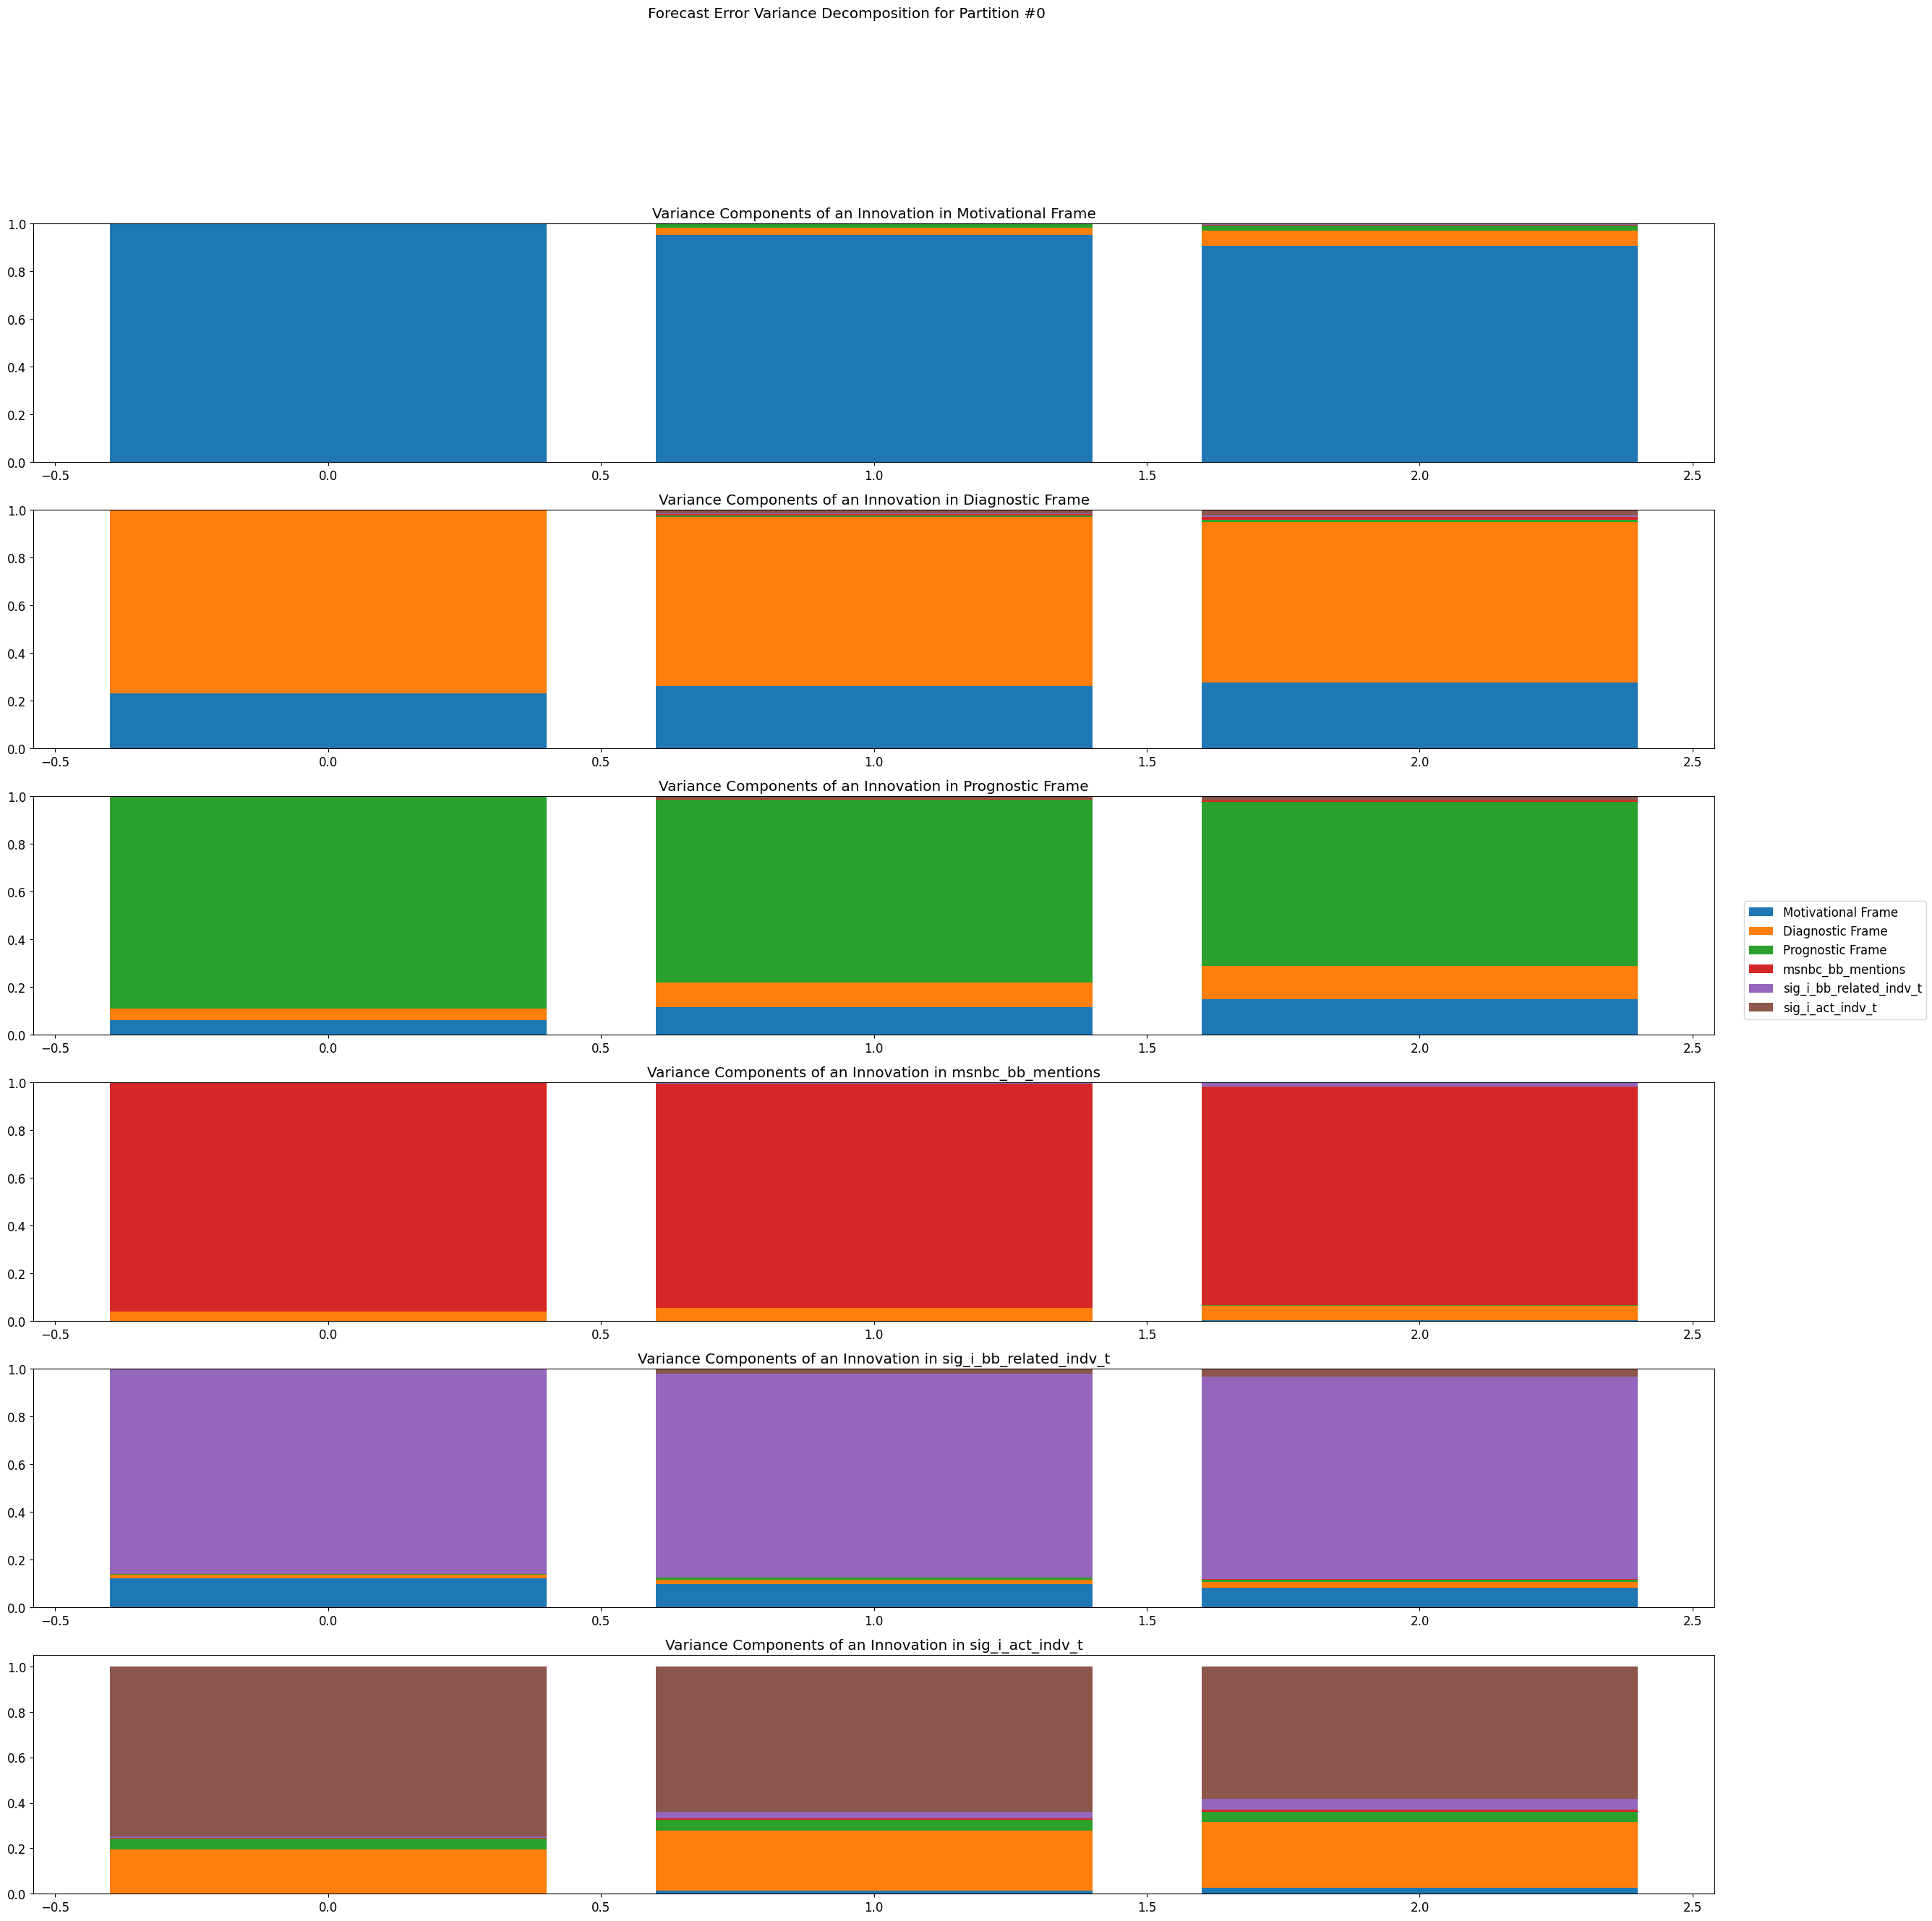

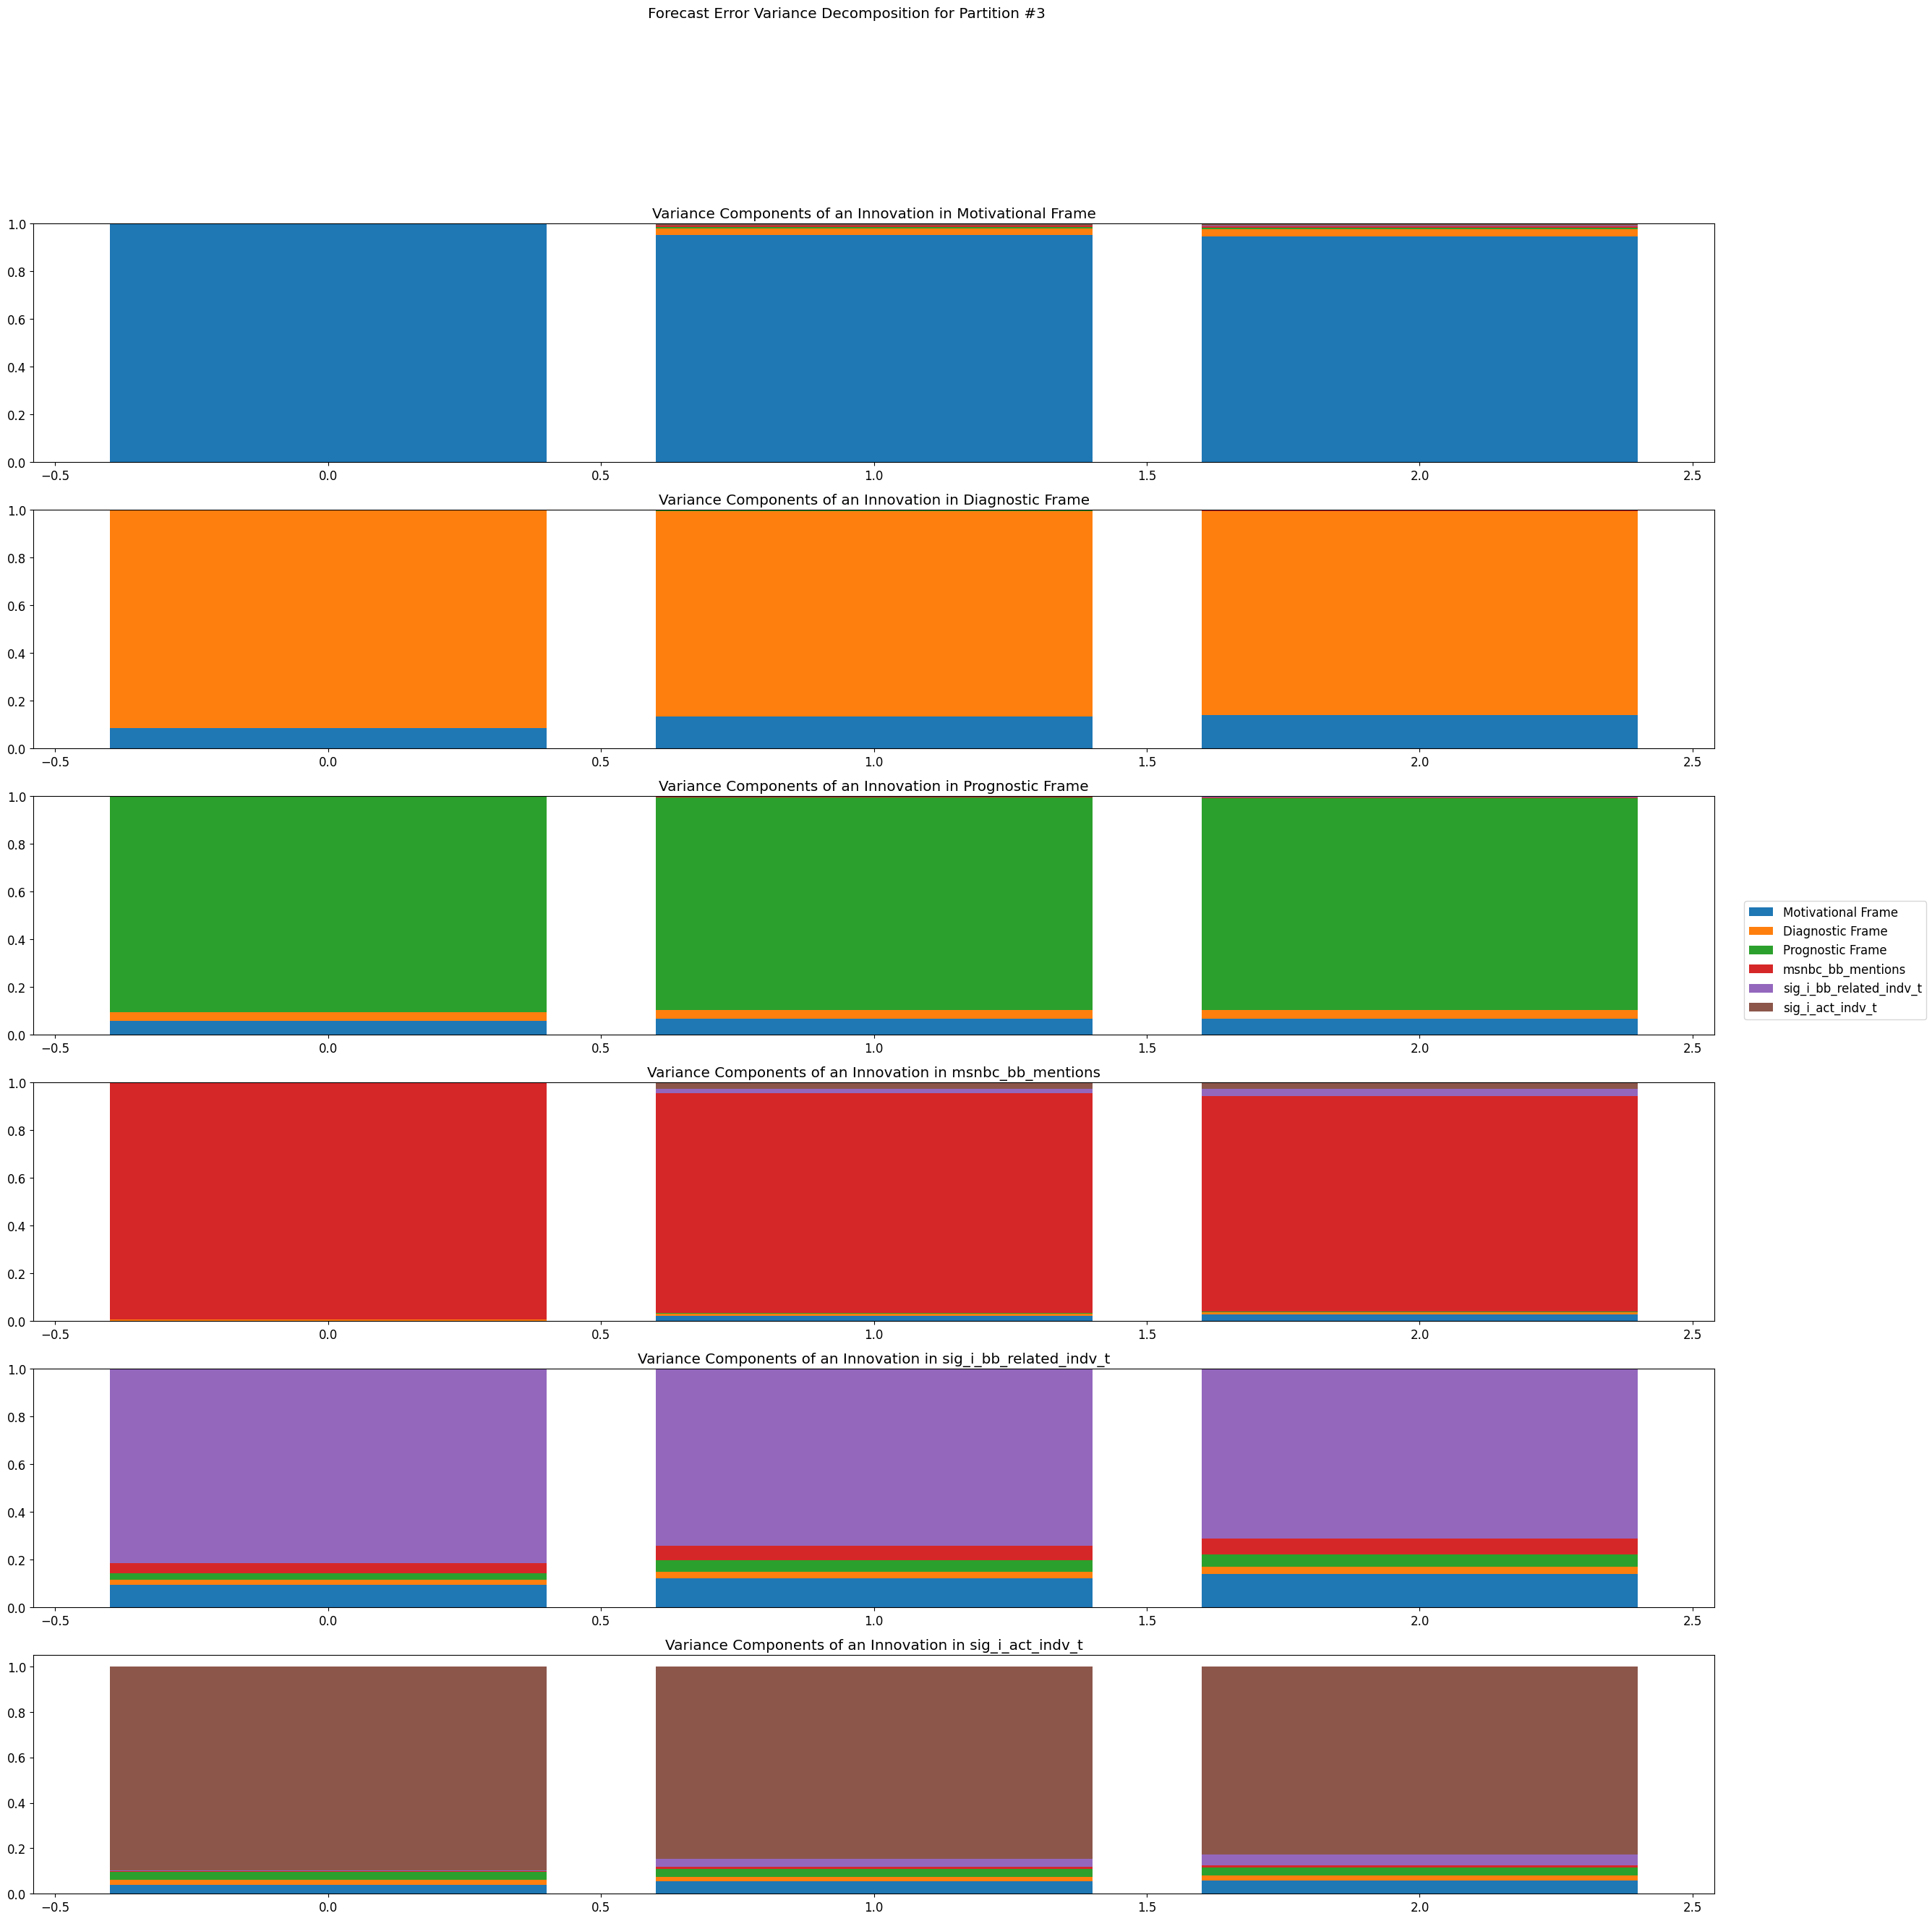

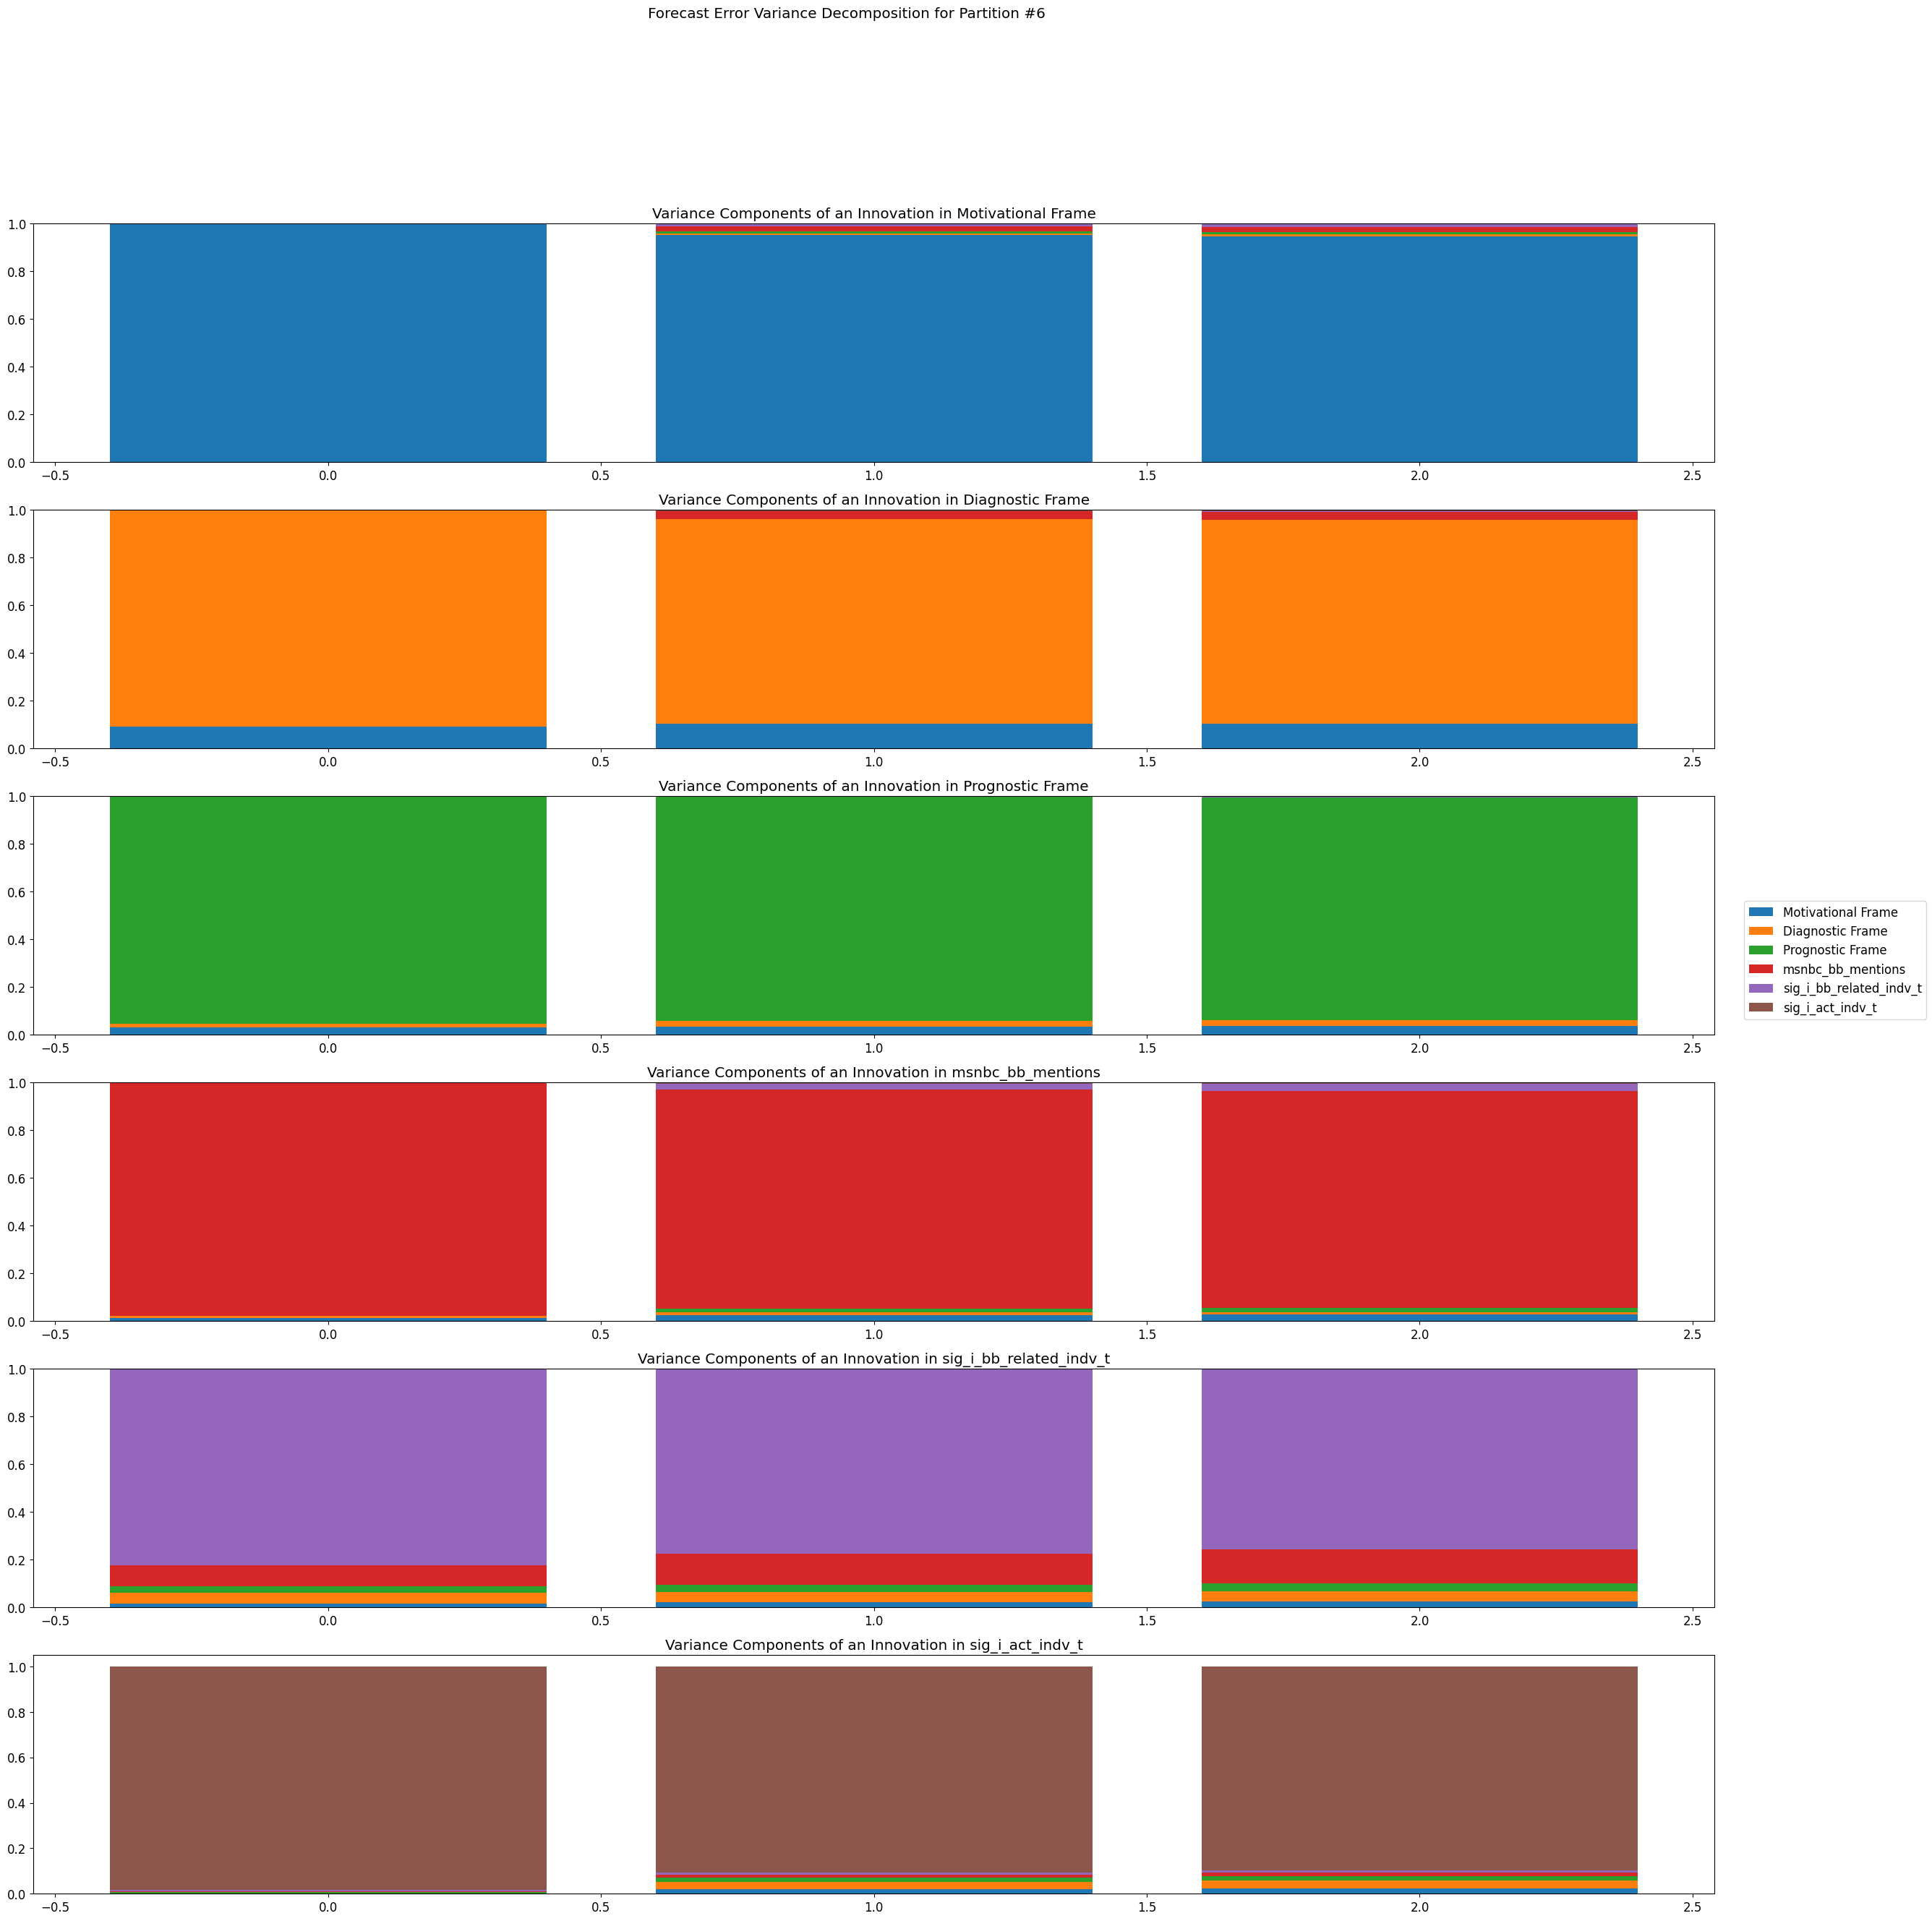

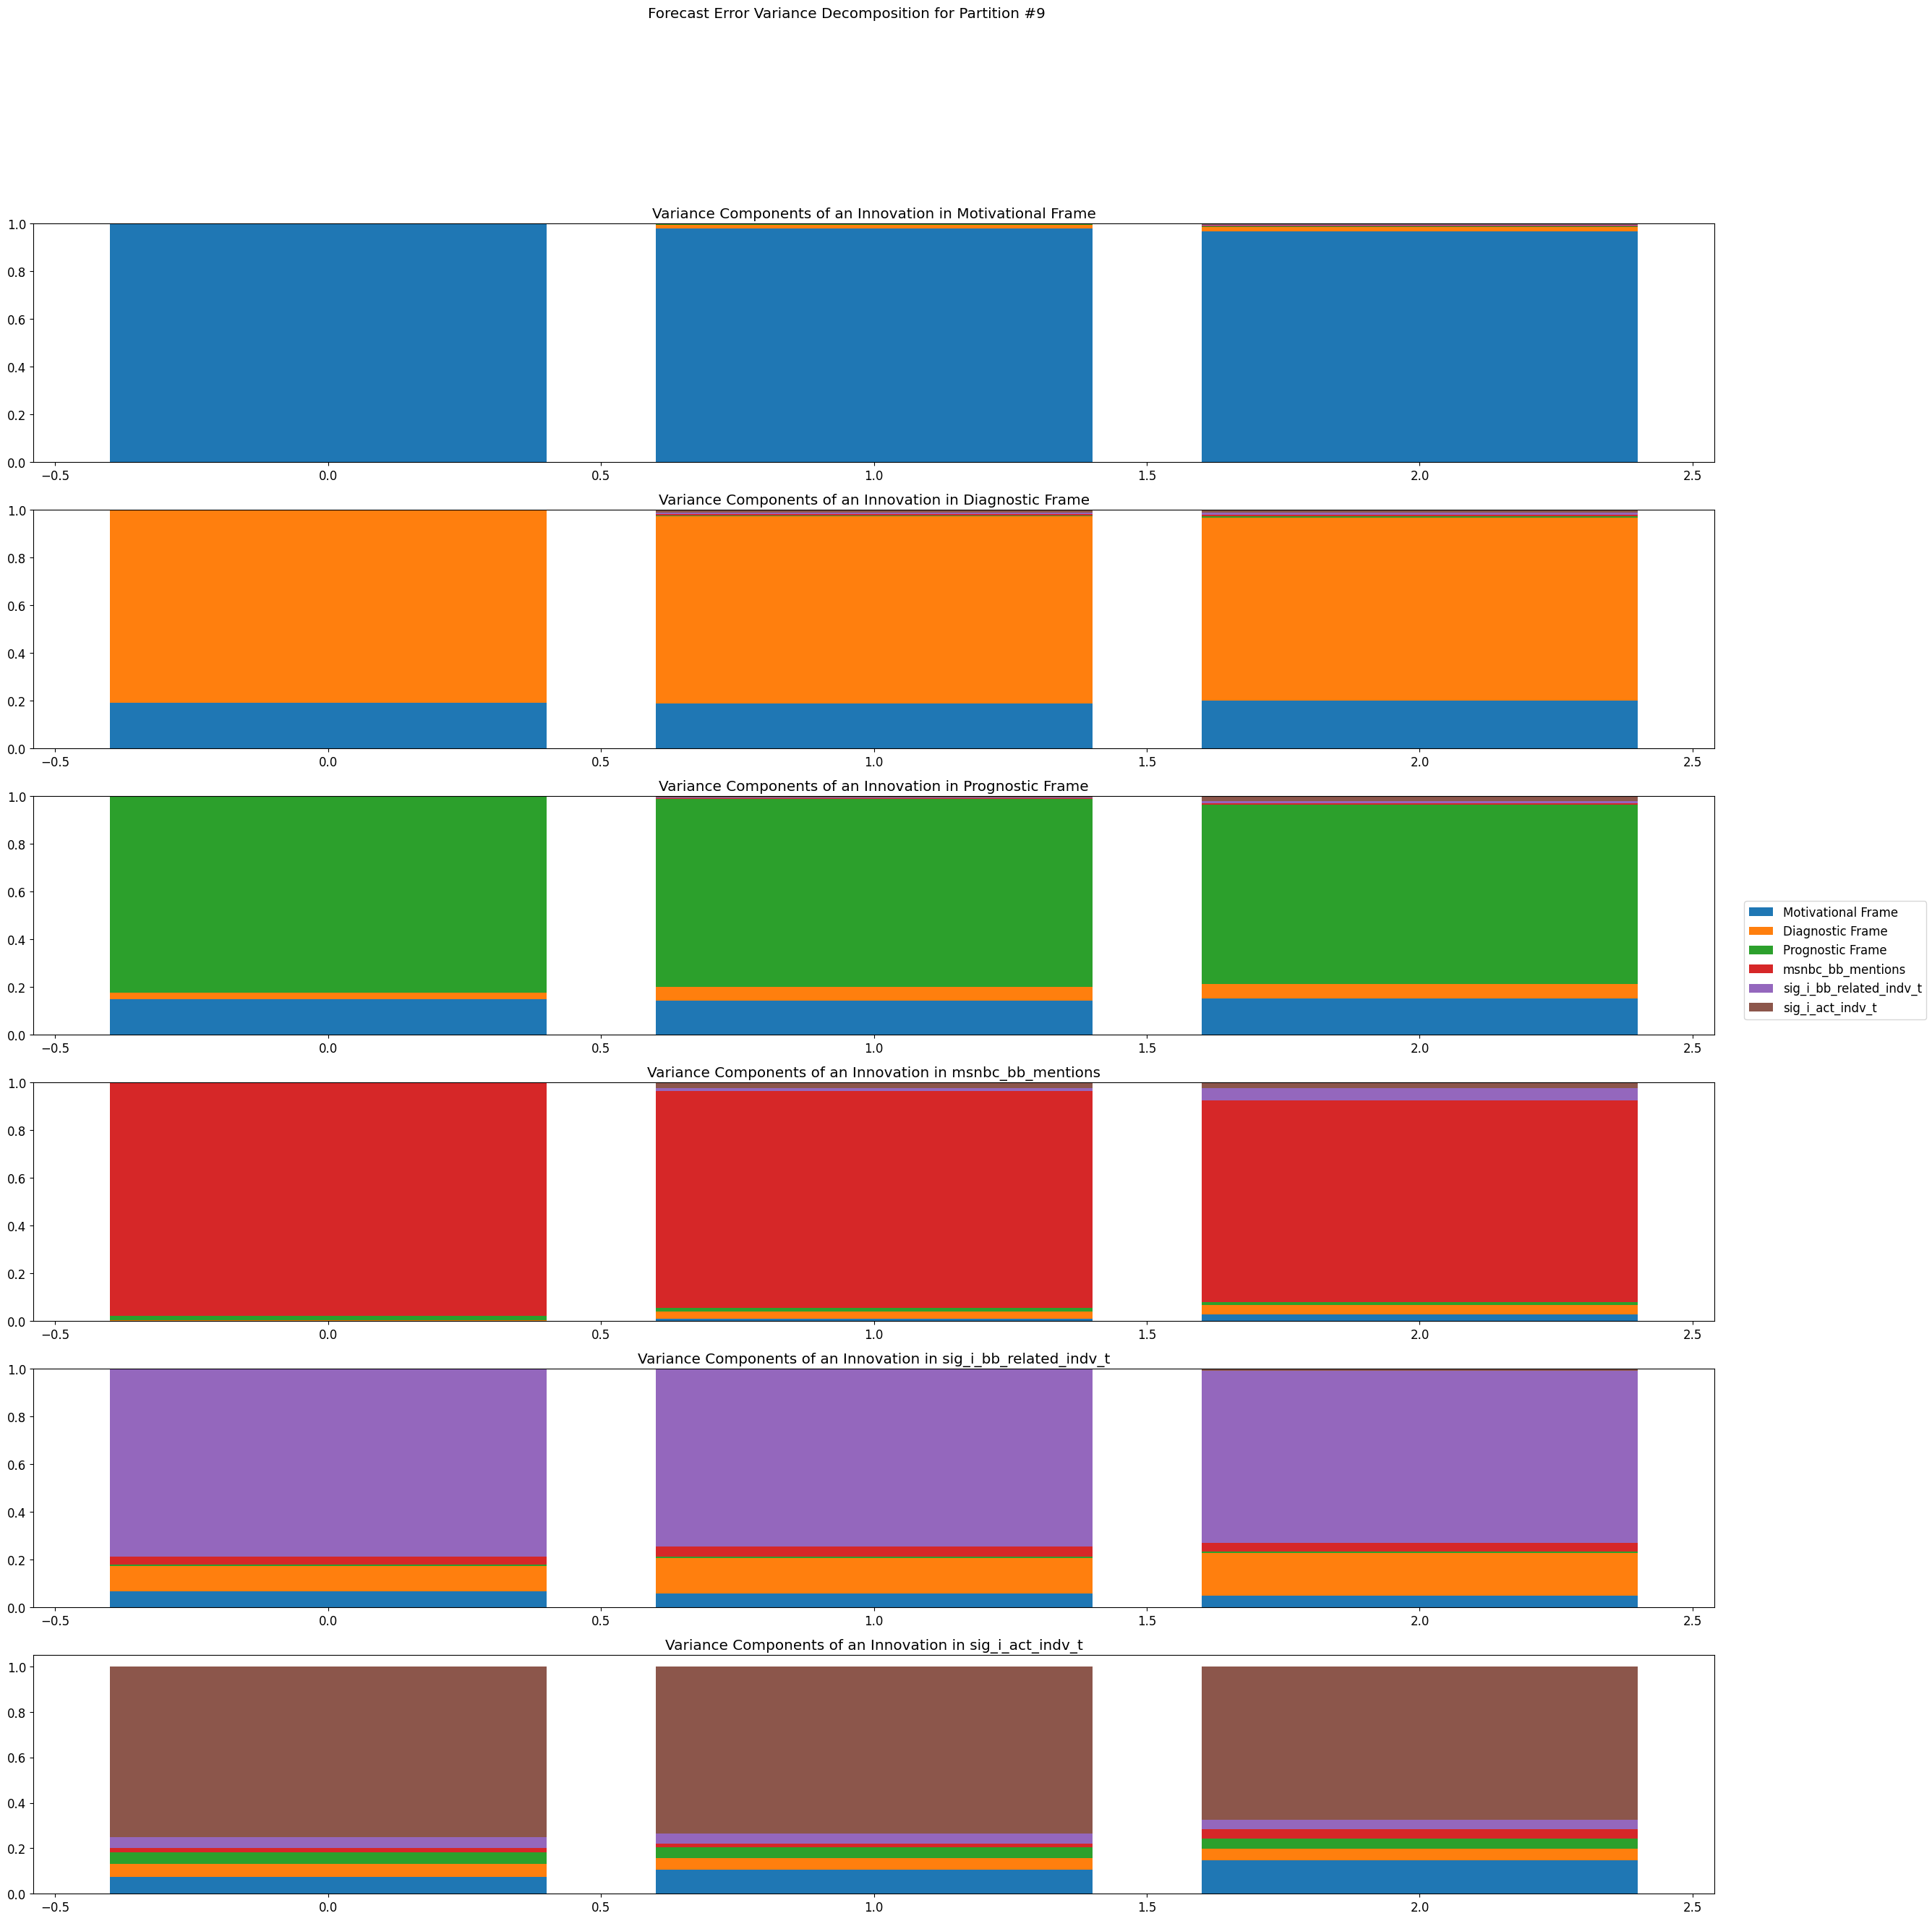

In [17]:
selected_parts = [0,3,6,9]
equation_names = partition_models[4].fevd(3).names
fevd_h = 3
neqs = len(equation_names)
for k, pm in enumerate(partition_models):
    if not k in selected_parts:
        continue
    limits = pm.fevd(fevd_h).decomp.cumsum(2)
    fig, axes = plt.subplots(nrows=neqs, figsize=(30,30))
    fig.suptitle(f"Forecast Error Variance Decomposition for Partition #{k}")
    for i, equation_name in enumerate(equation_names):
        ax = axes[i]
        handles = []
        curr_limits = limits[i].T
        
        ticks = np.arange(fevd_h)
        
        for j in range(neqs):
            lower = curr_limits[j-1] if j > 0 else 0
            upper = curr_limits[j]
            handle = ax.bar(
                ticks,
                upper - lower,
                bottom = lower,
                color = f'C{j}',
                label=equation_names[j]
            )
            handles.append(handle)
        ax.set_title(f"Variance Components of an Innovation in {equation_name}")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right")
    

#partition_models[6].fevd(3)
# non-overlapping 1 4 7 10

In [18]:
h = 3
h_ahead = h+1
num_parts = len(ex_windows)
resps = collect_irs(partition_models, h, end_vars)
resps_dat = pd.DataFrame(resps)
var2ix = {make_var_name(var):ix for ix, var in enumerate(end_vars)}


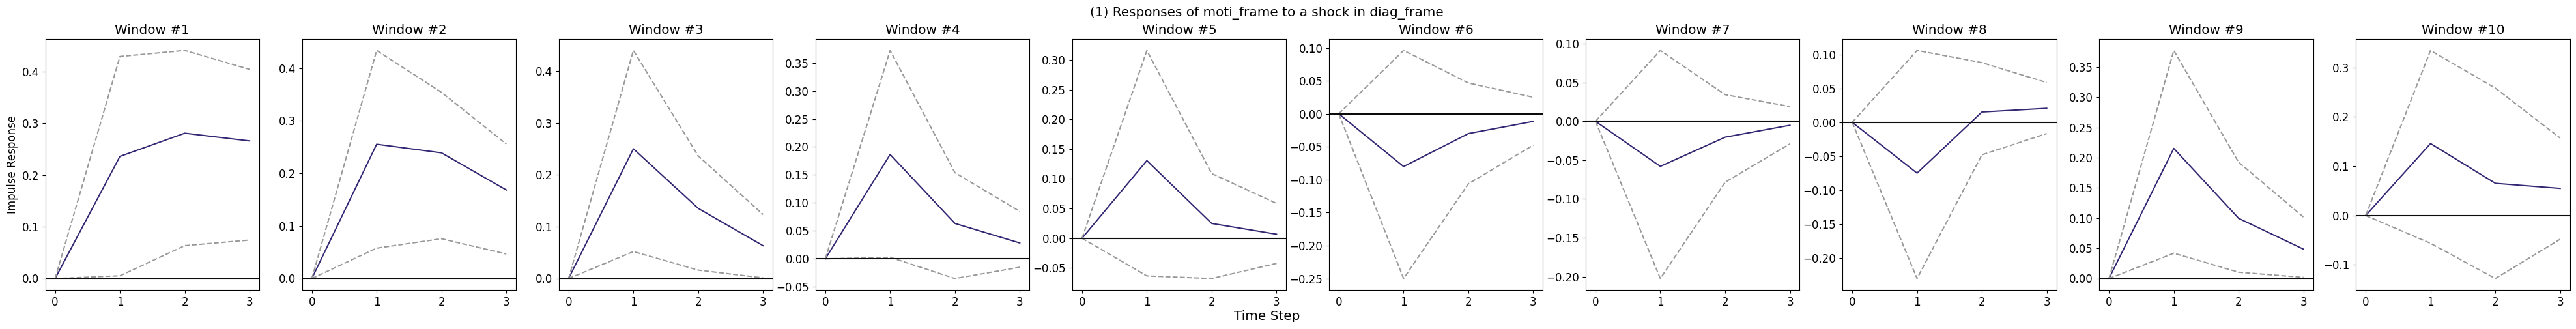

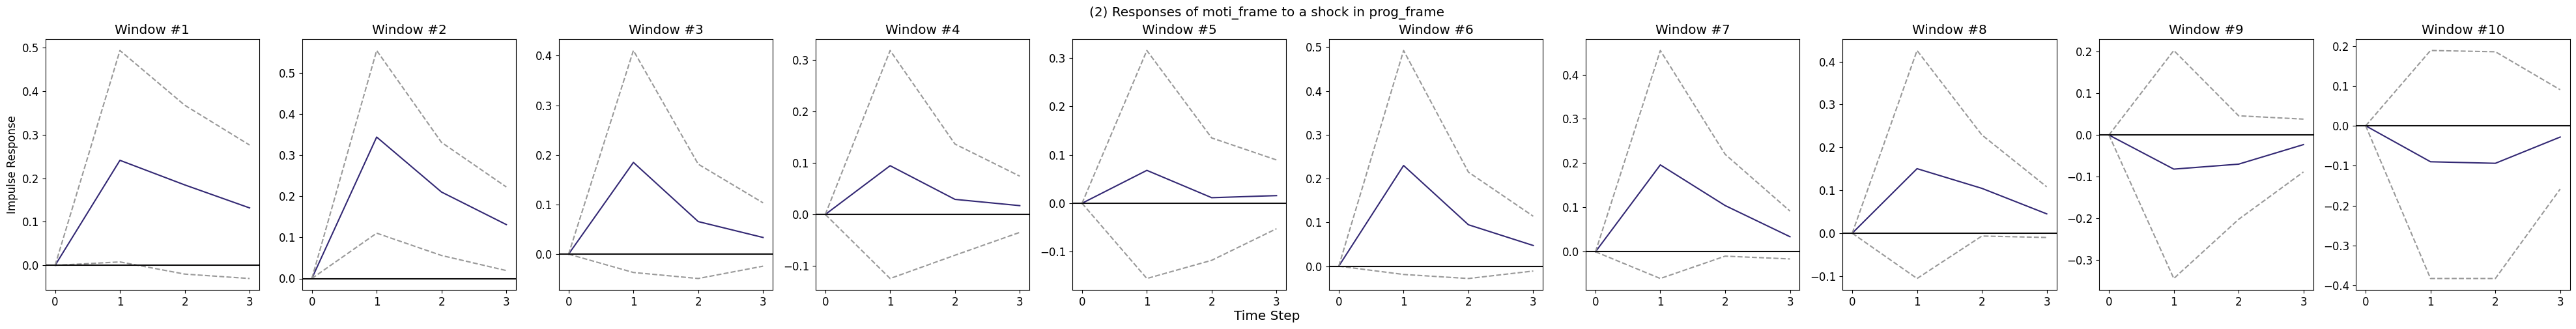

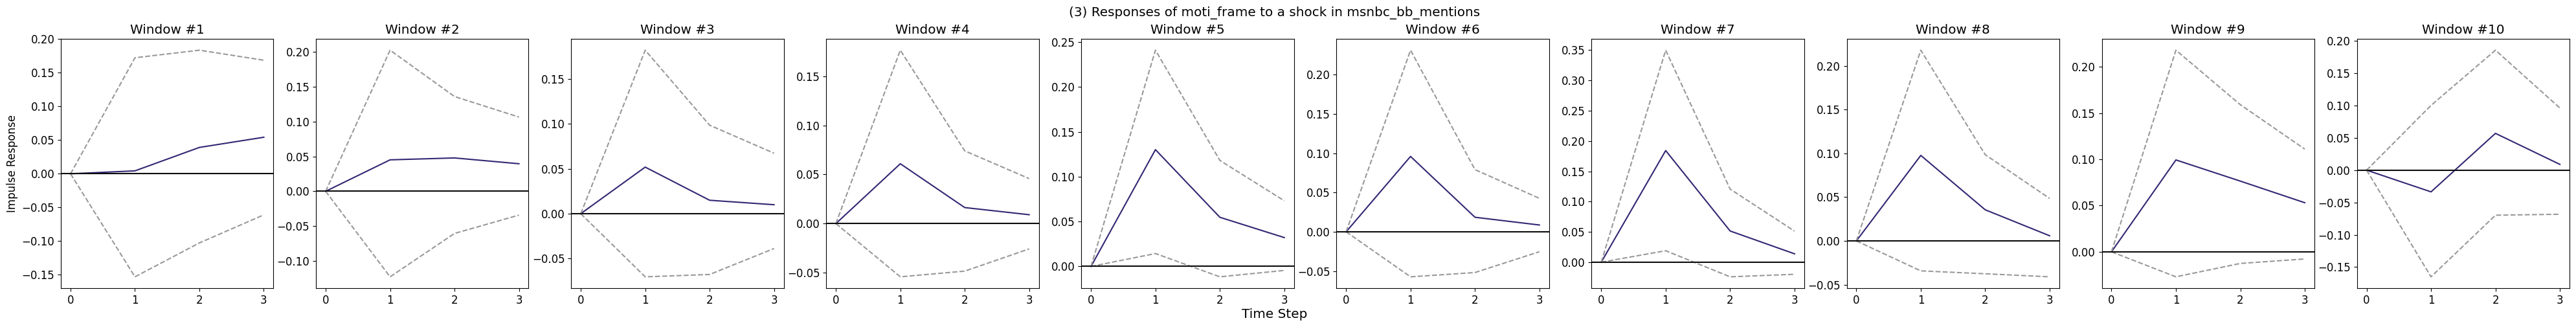

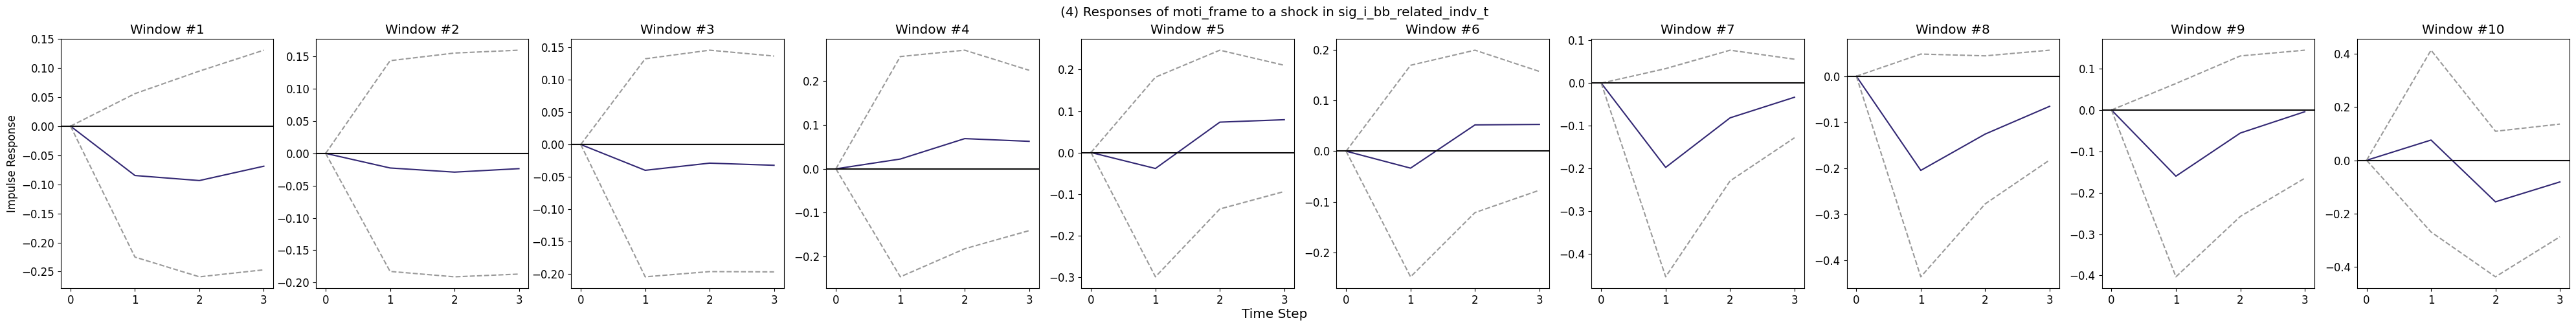

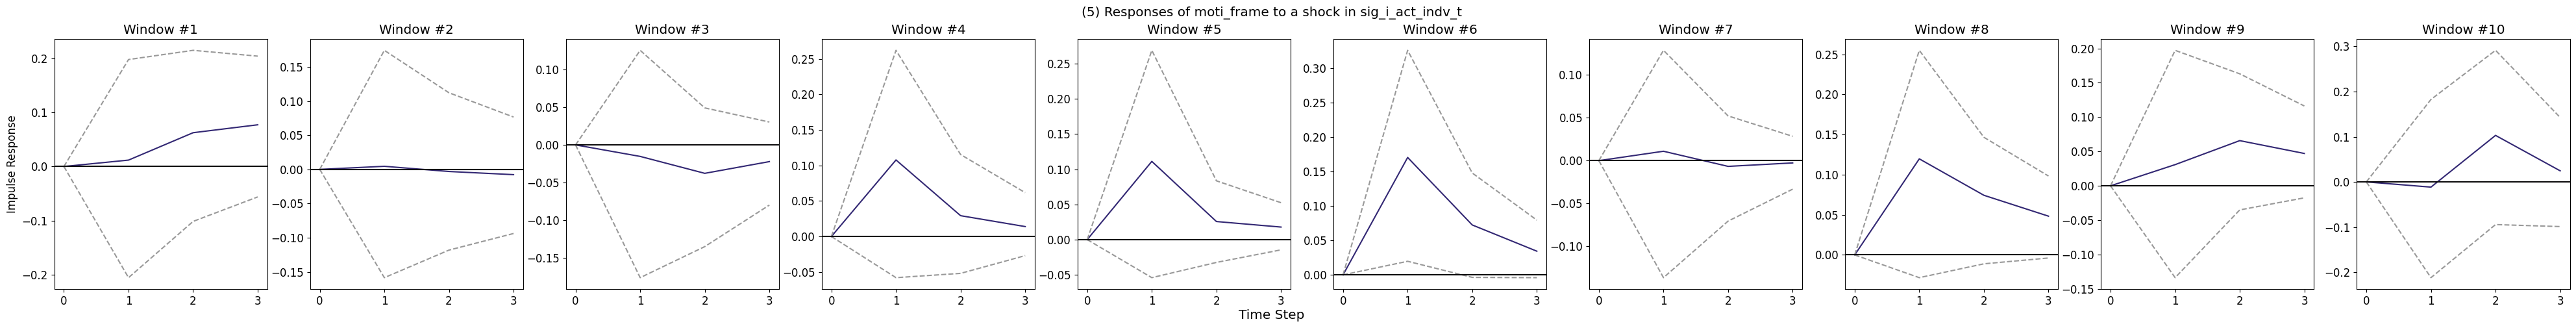

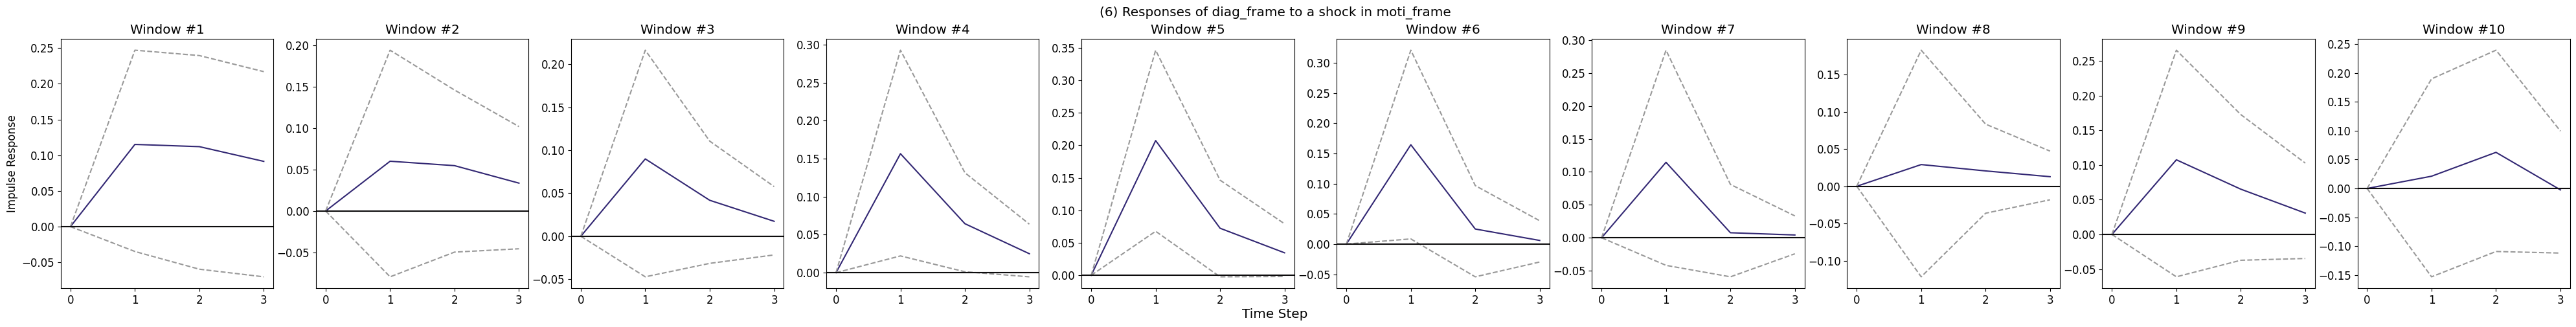

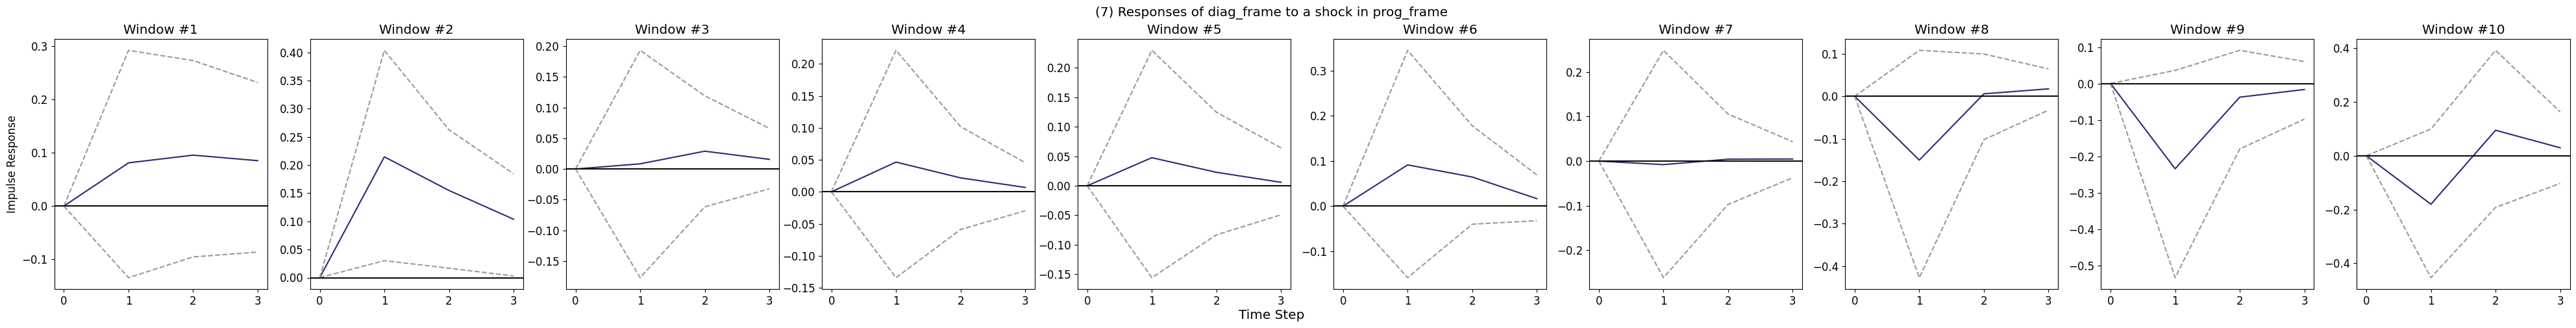

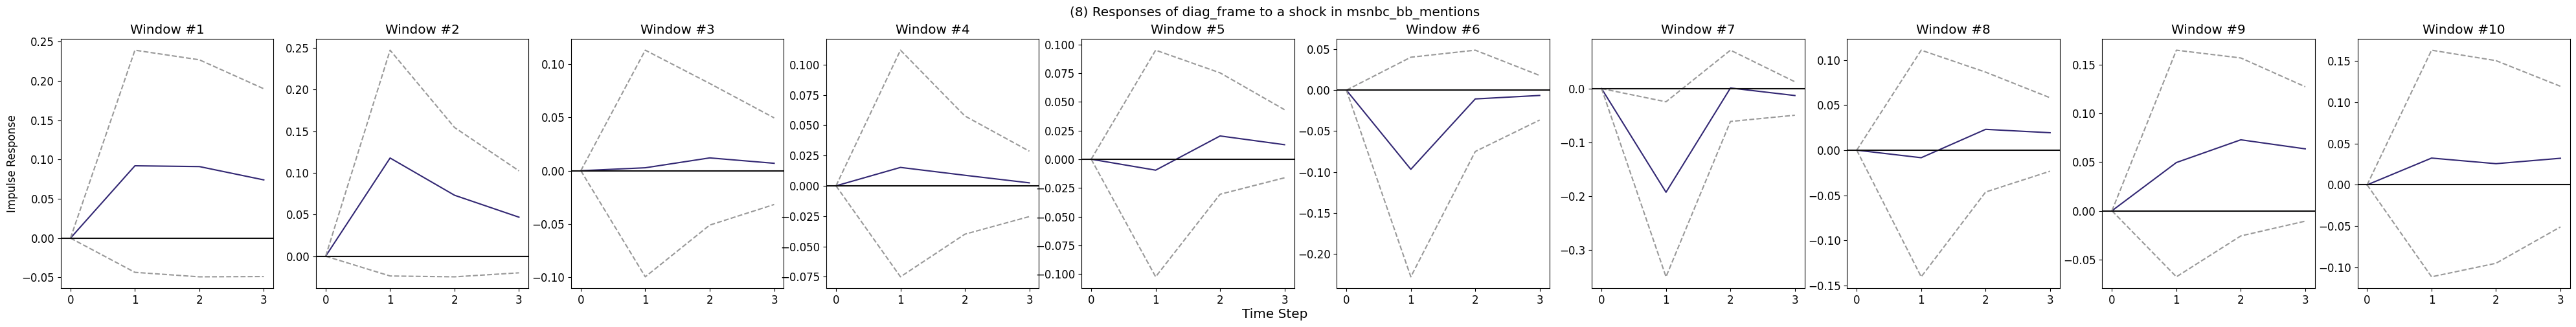

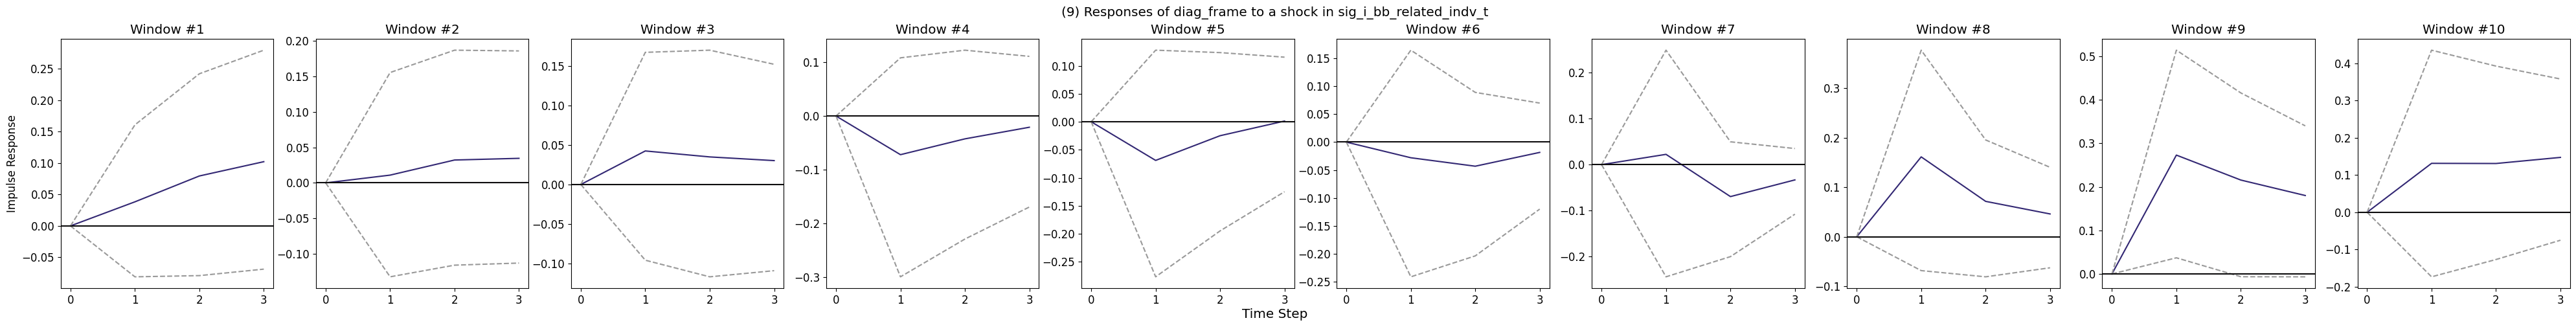

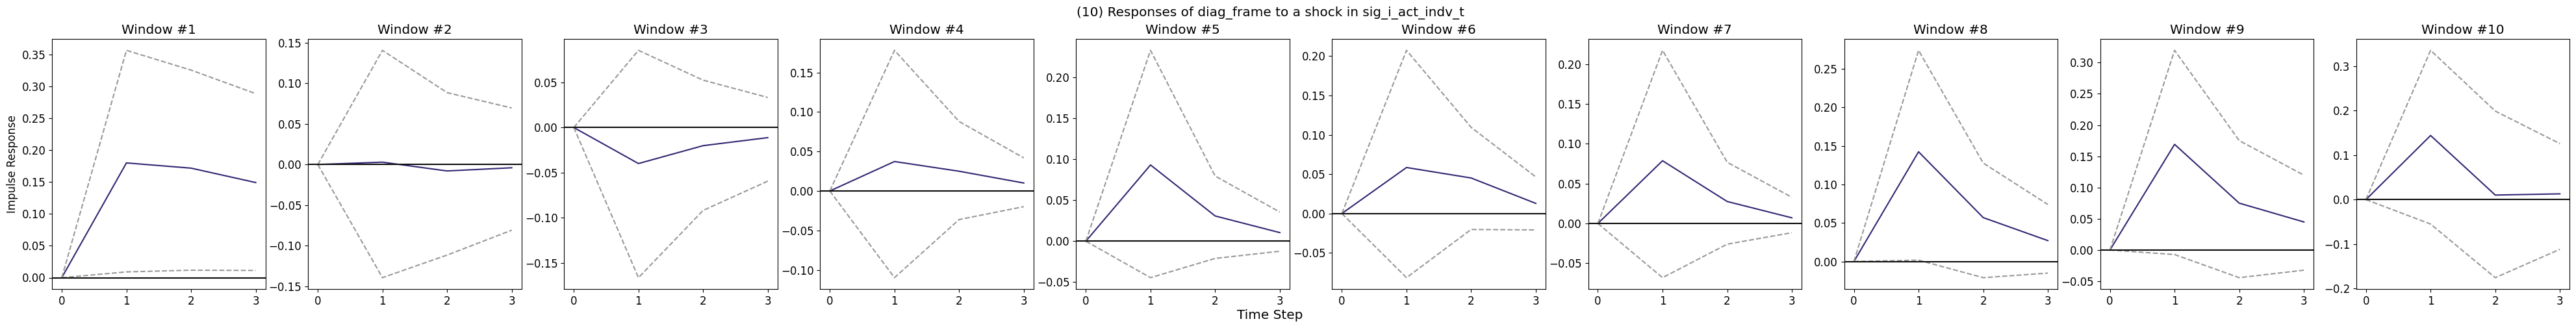

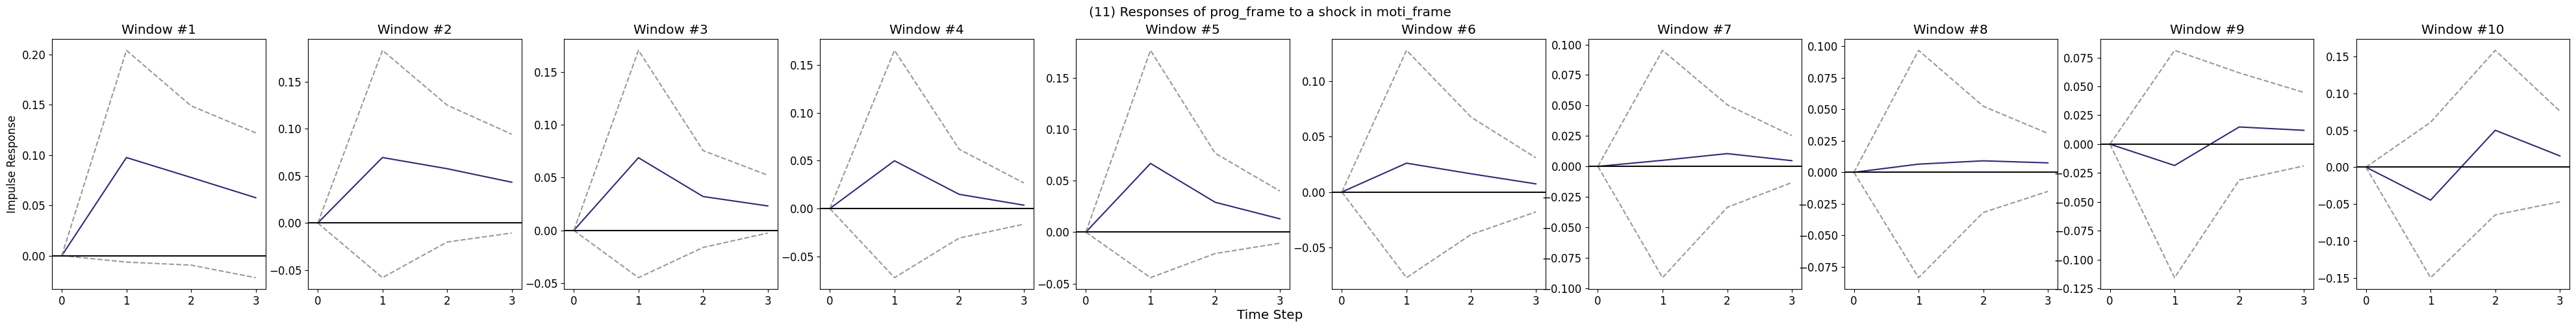

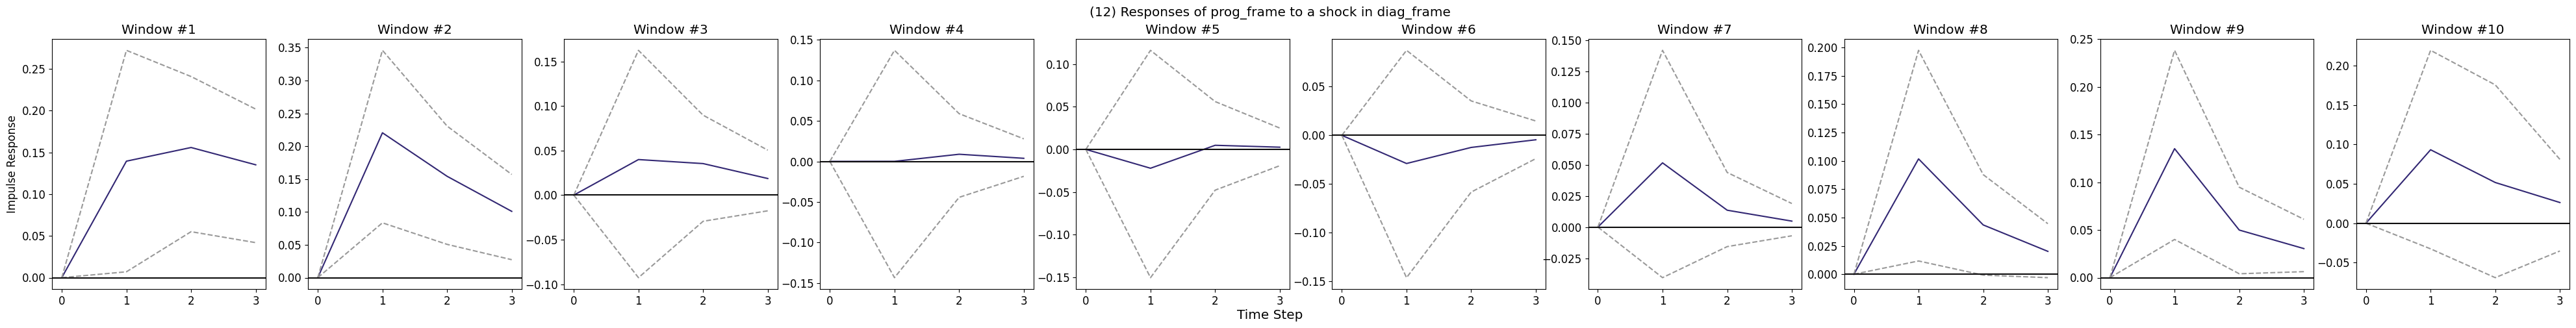

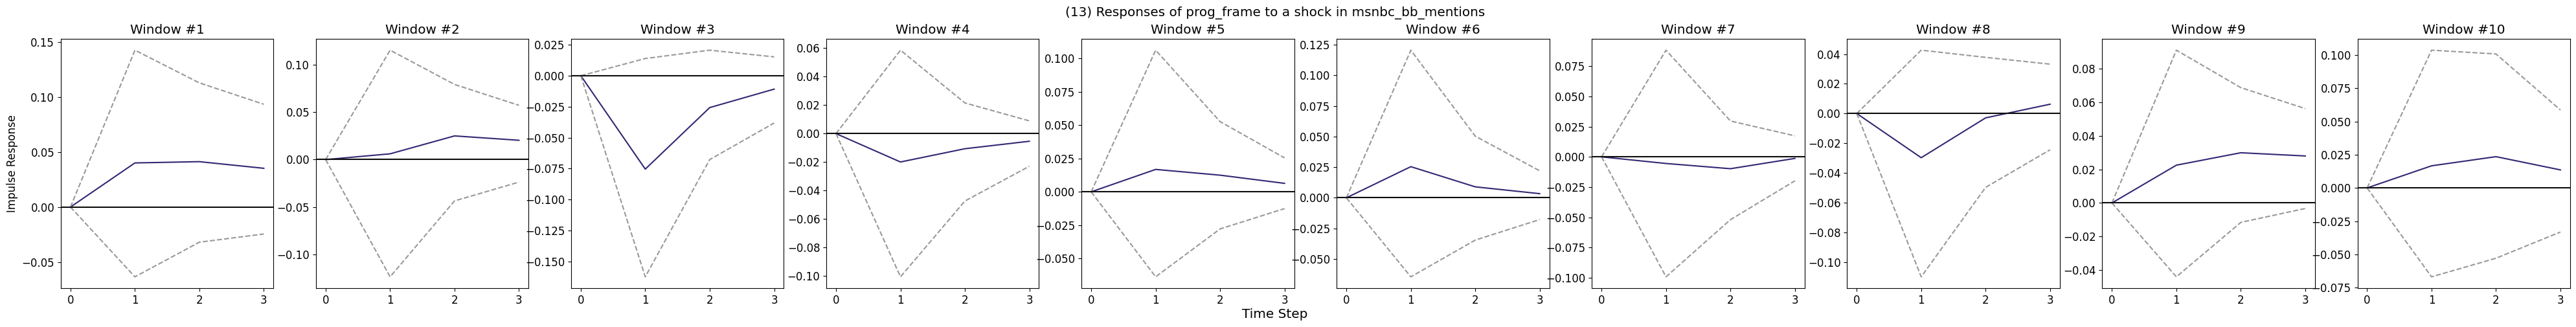

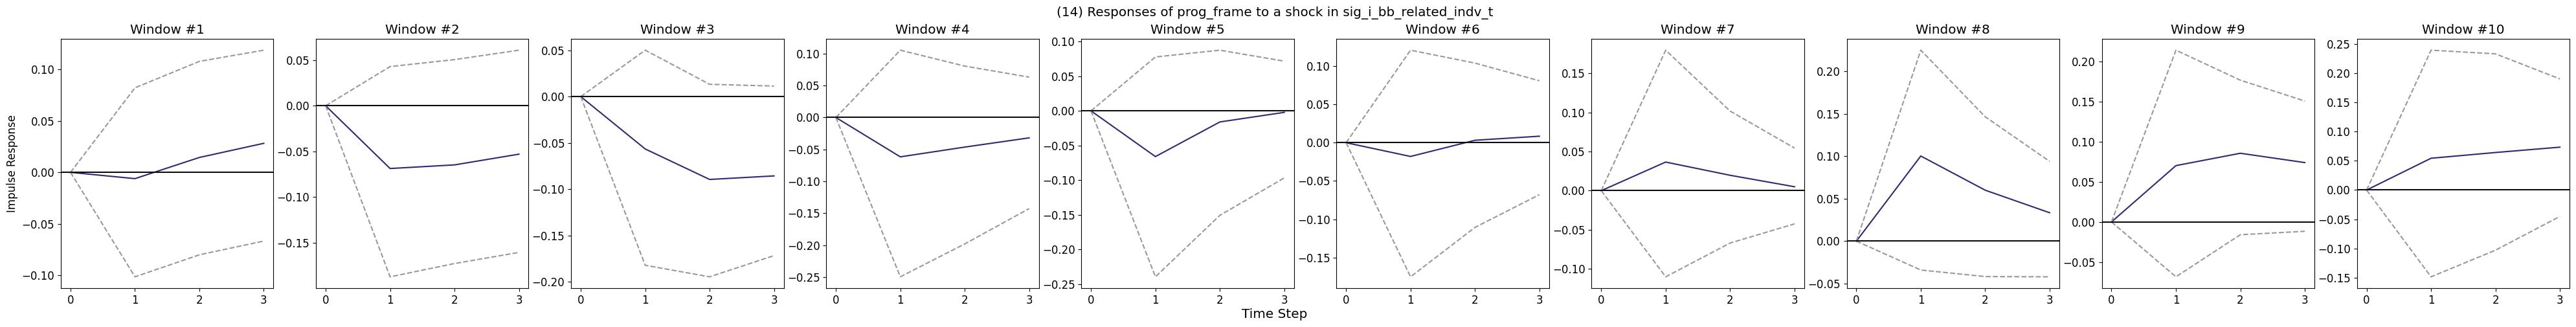

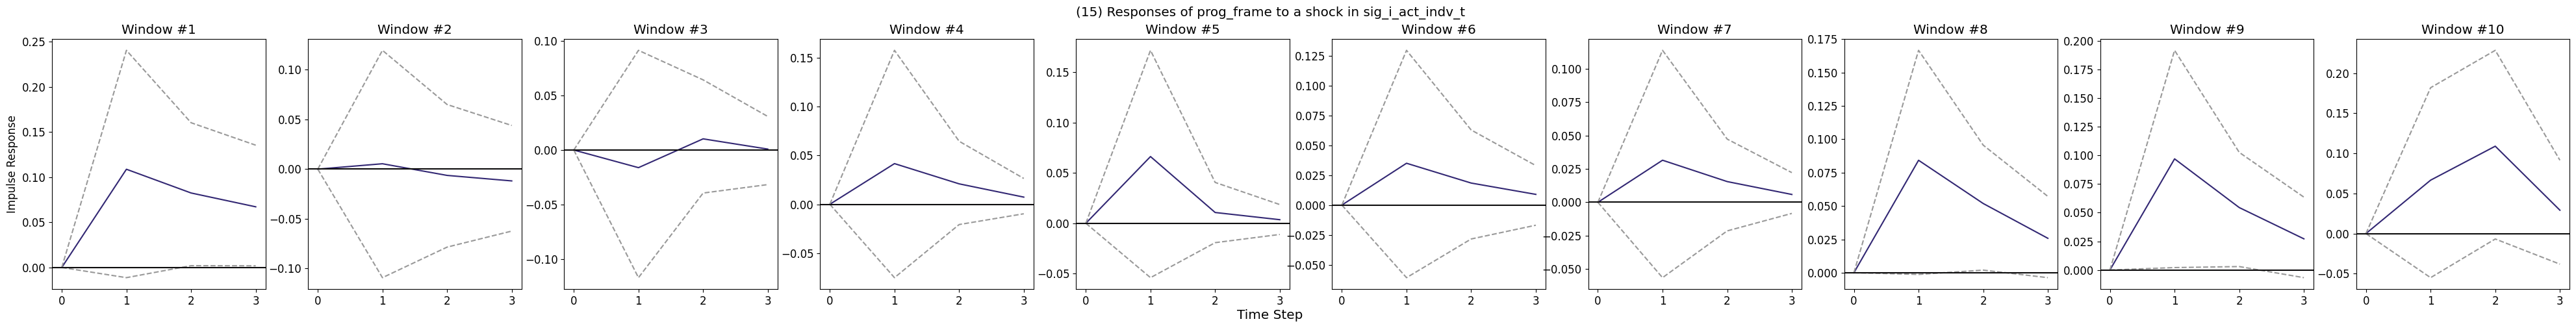

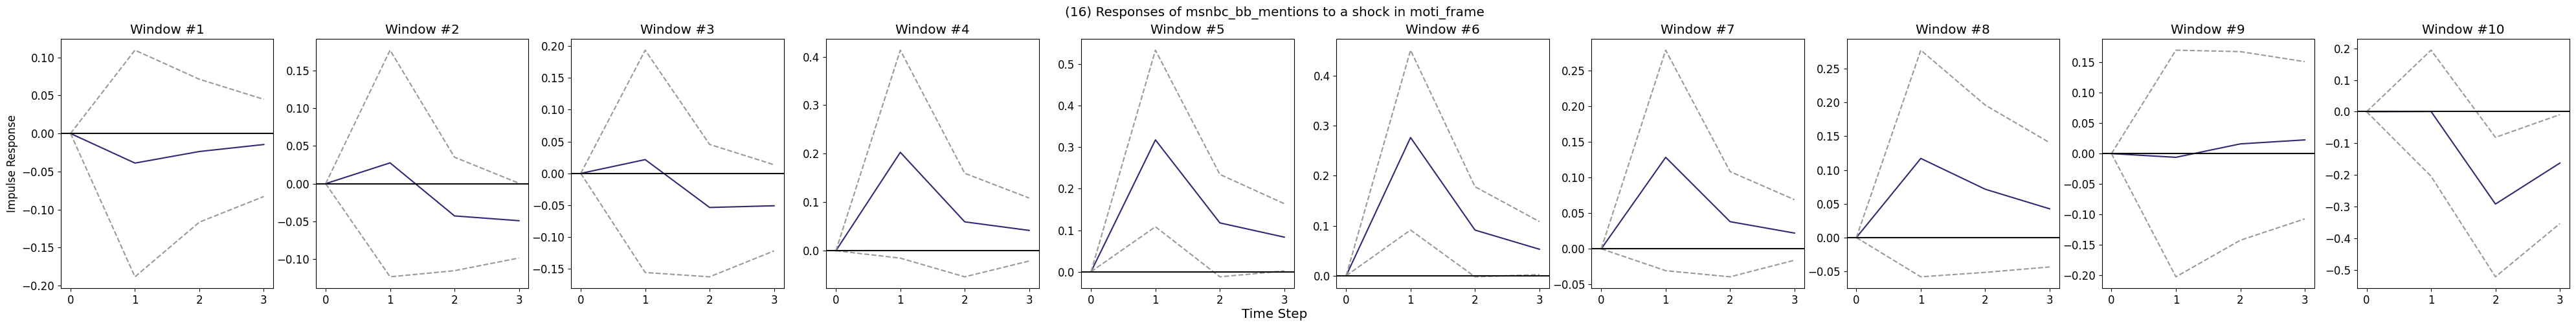

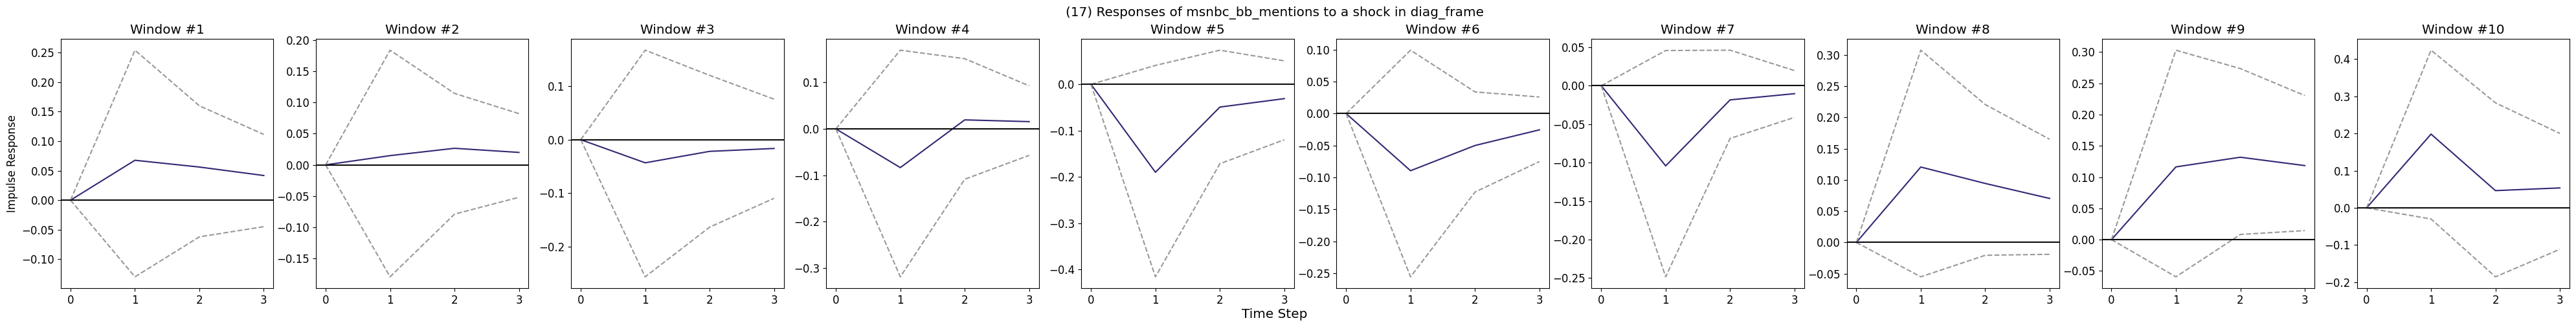

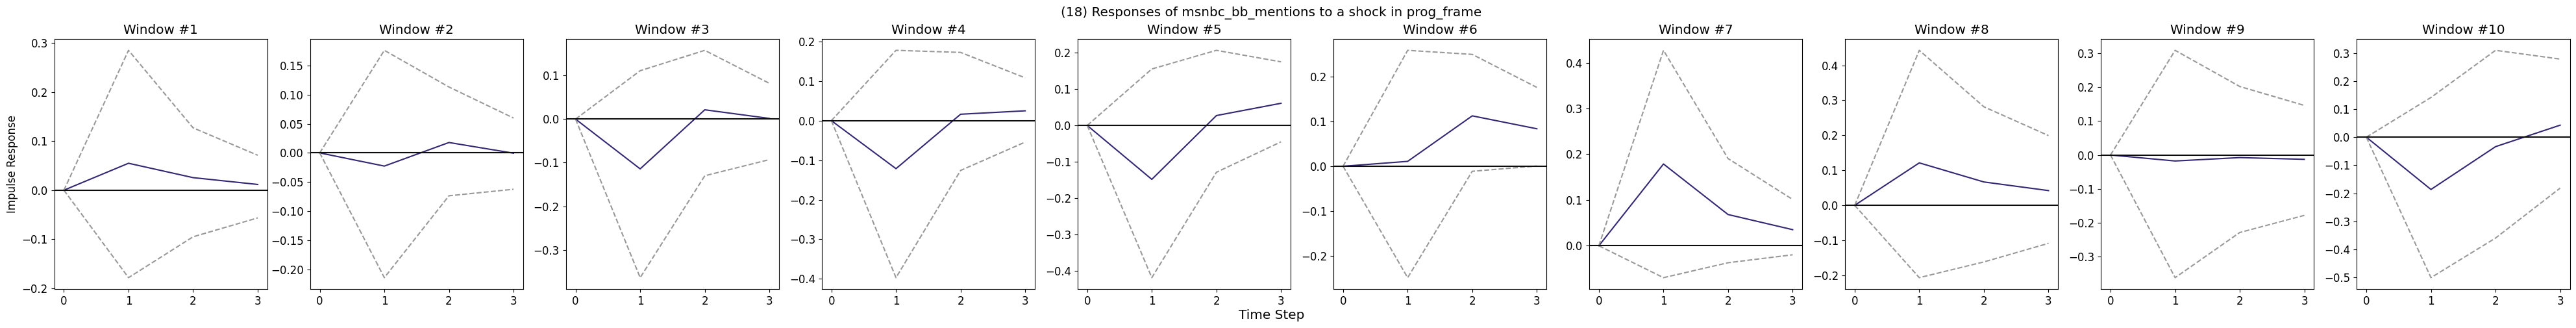

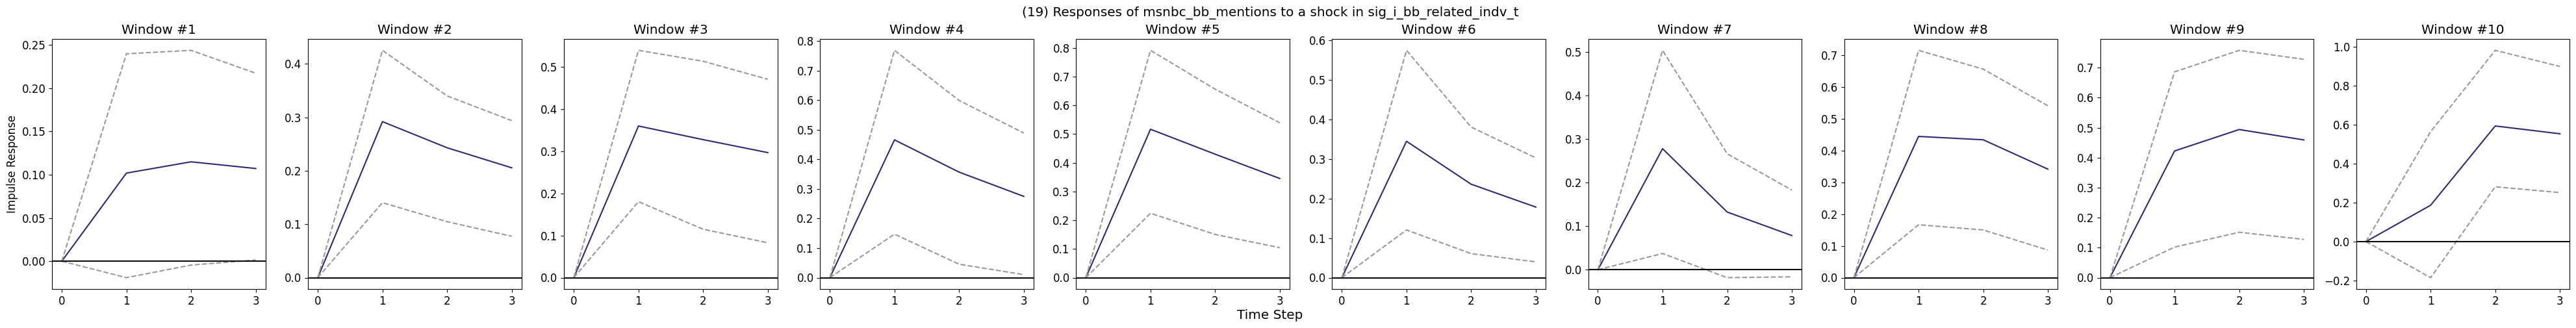

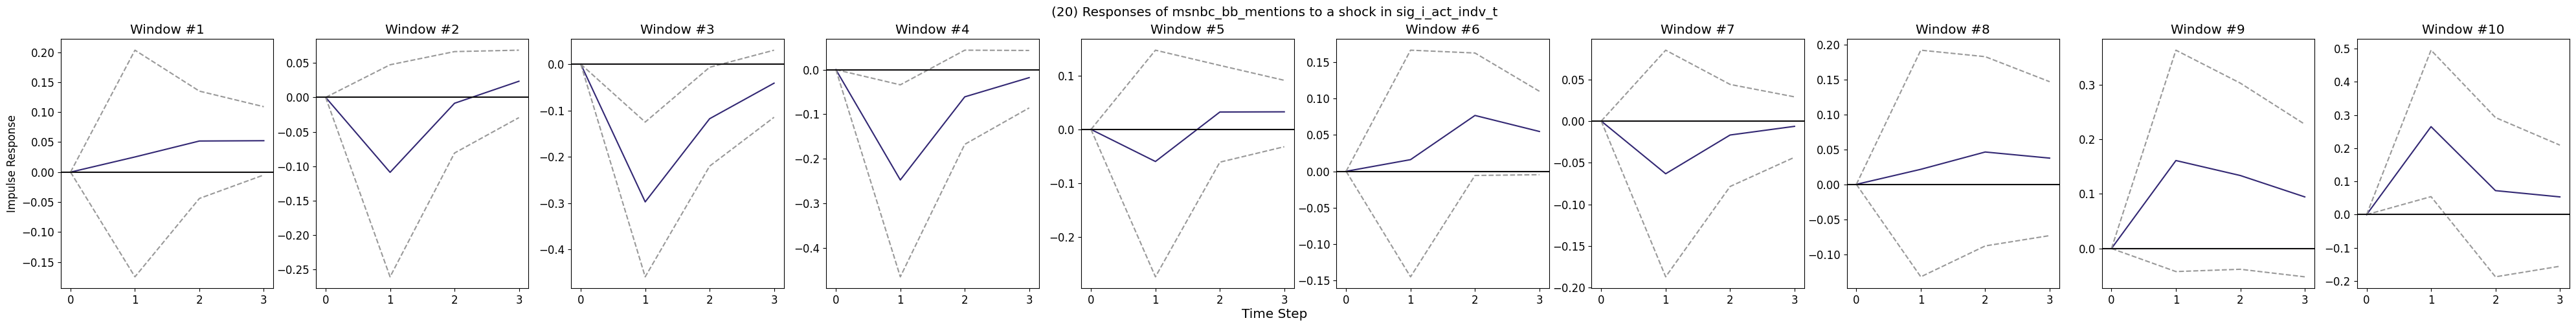

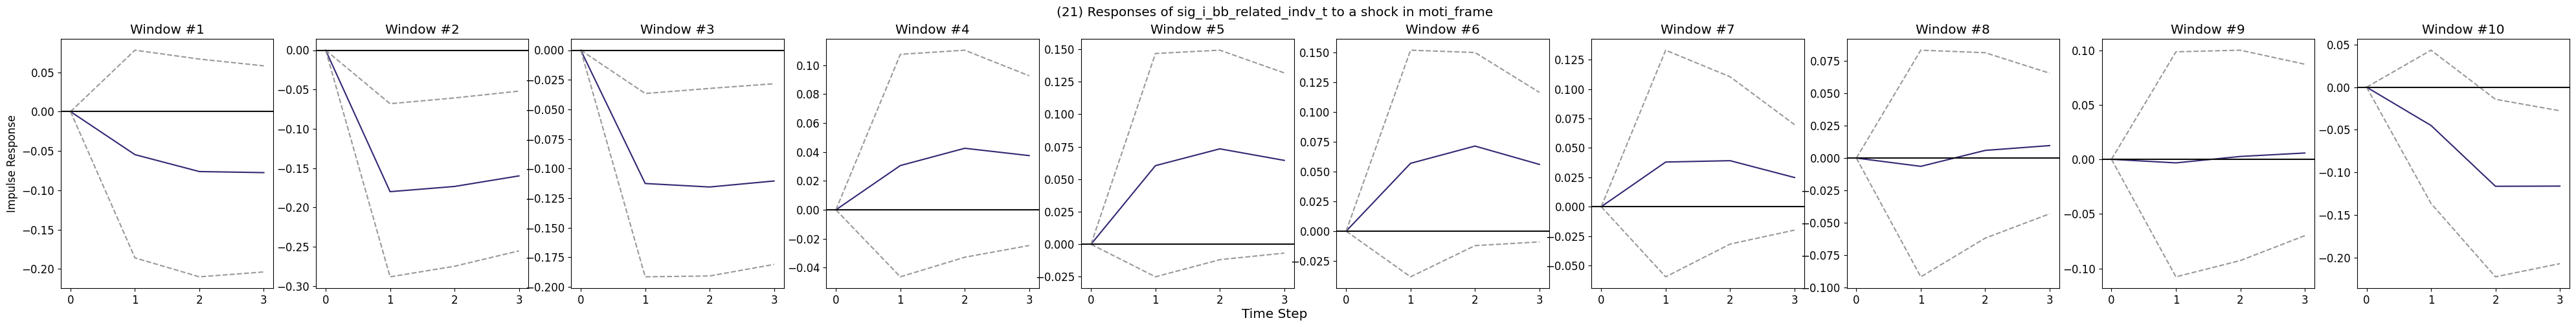

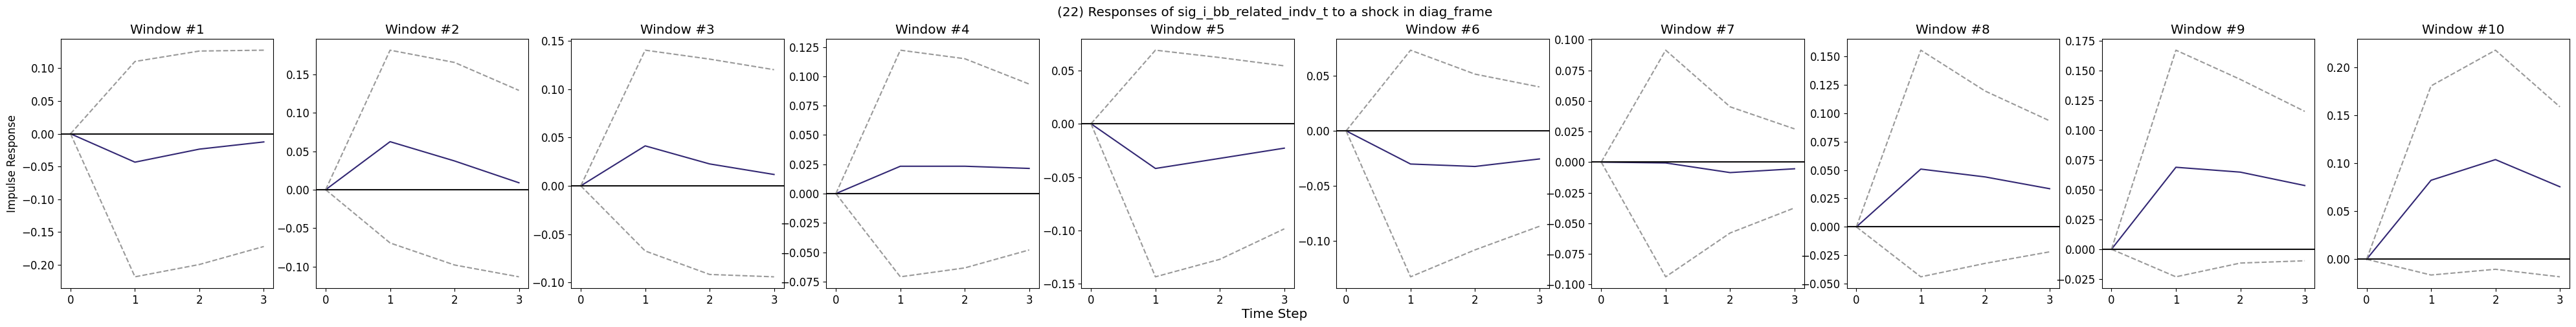

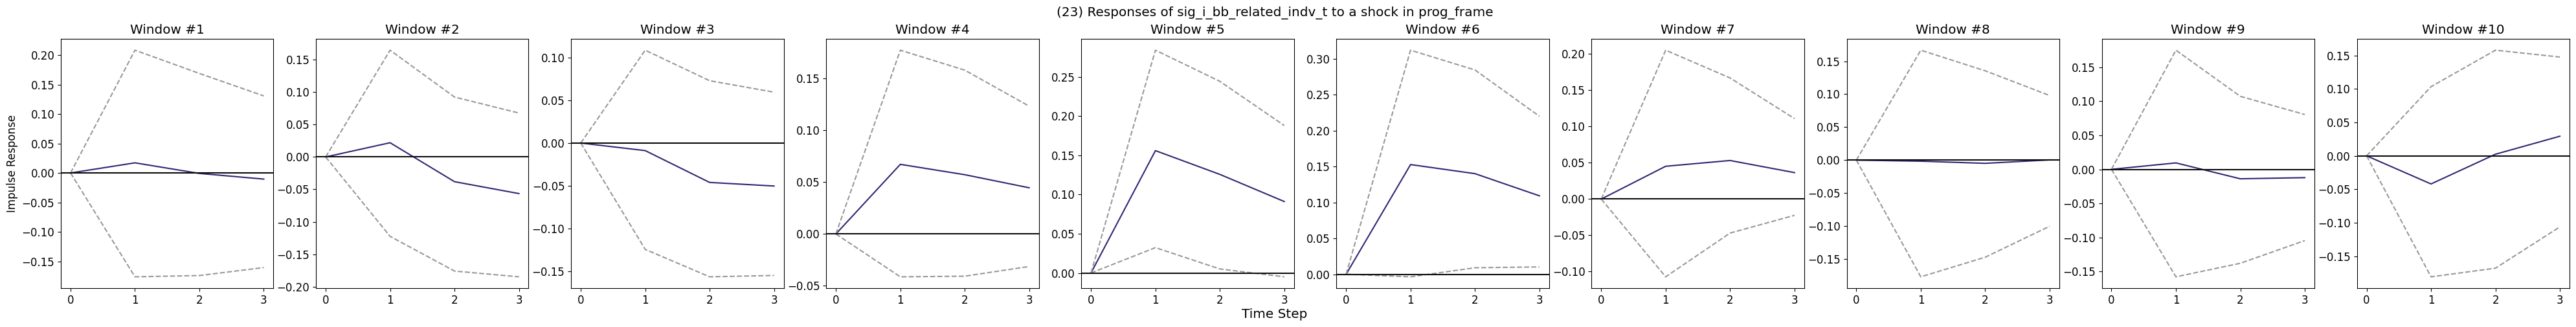

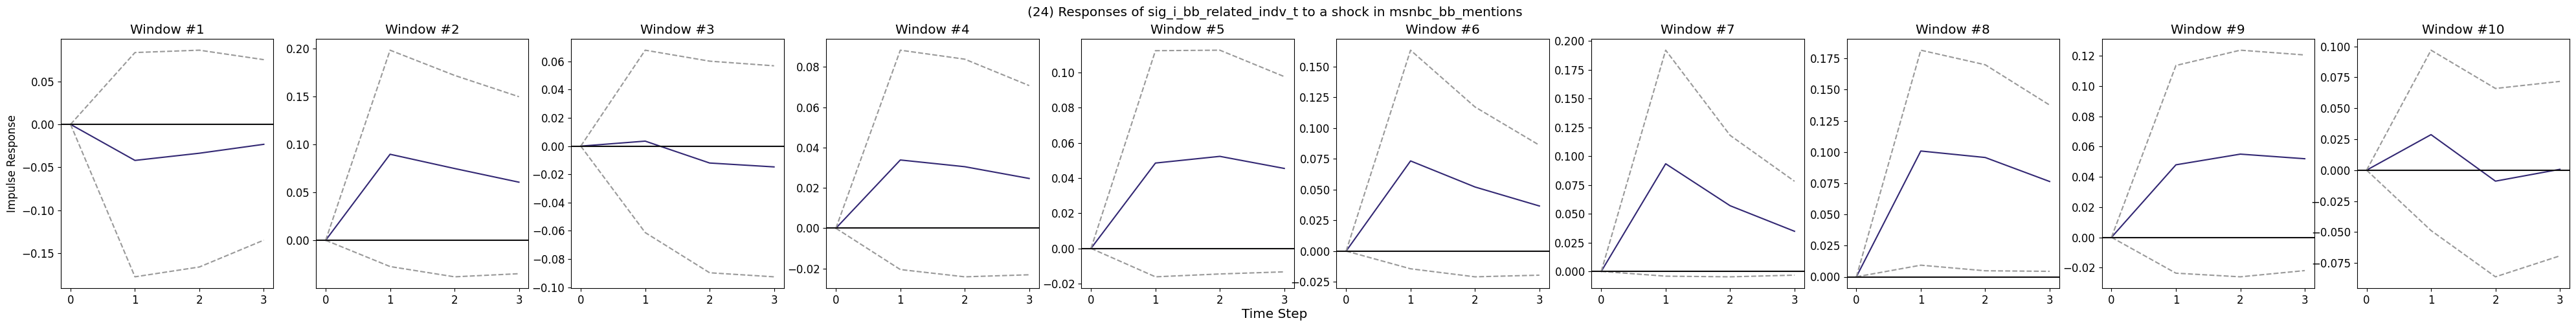

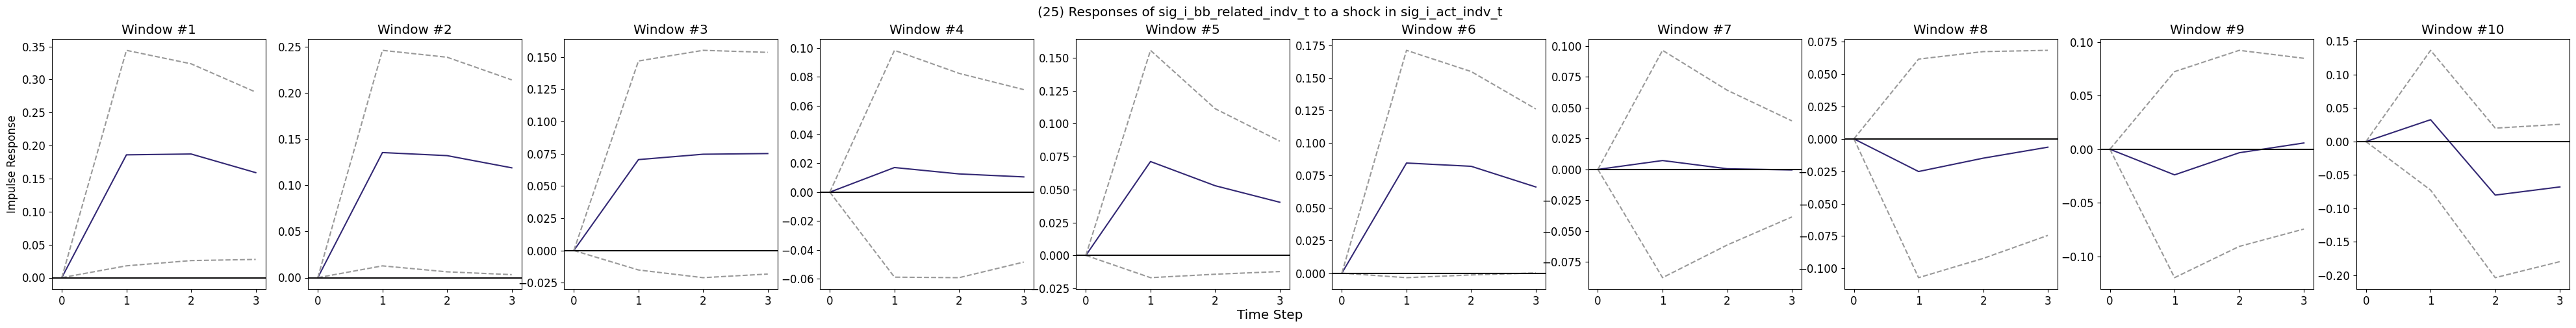

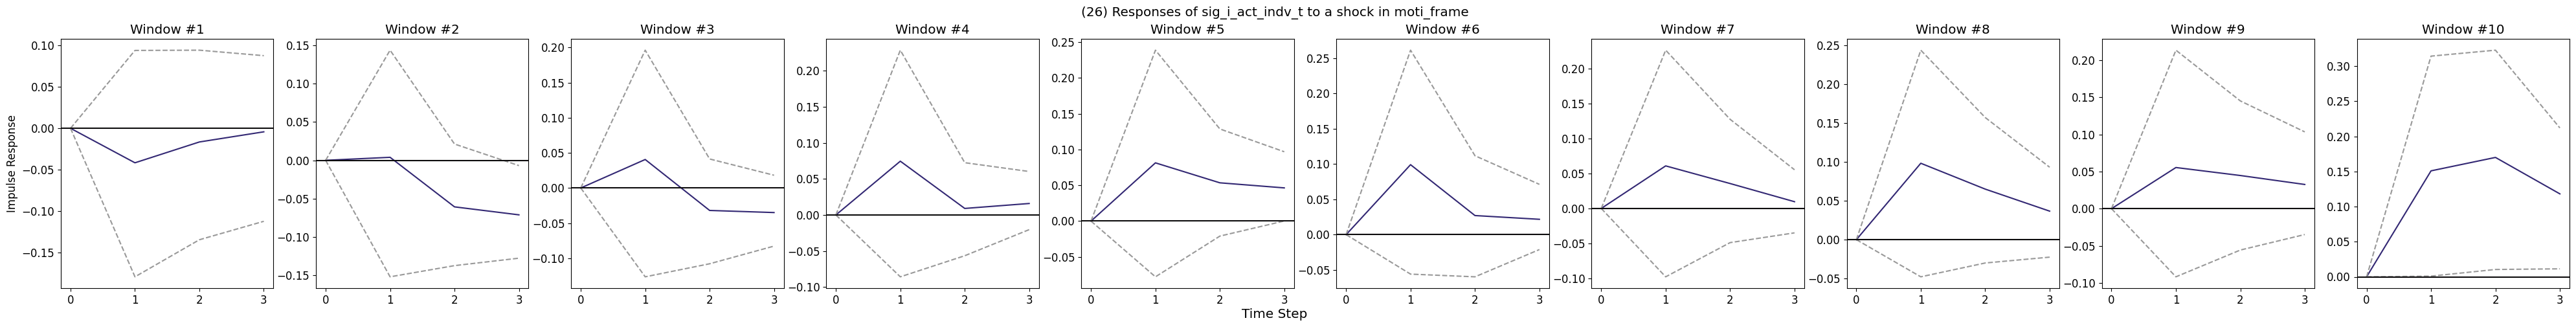

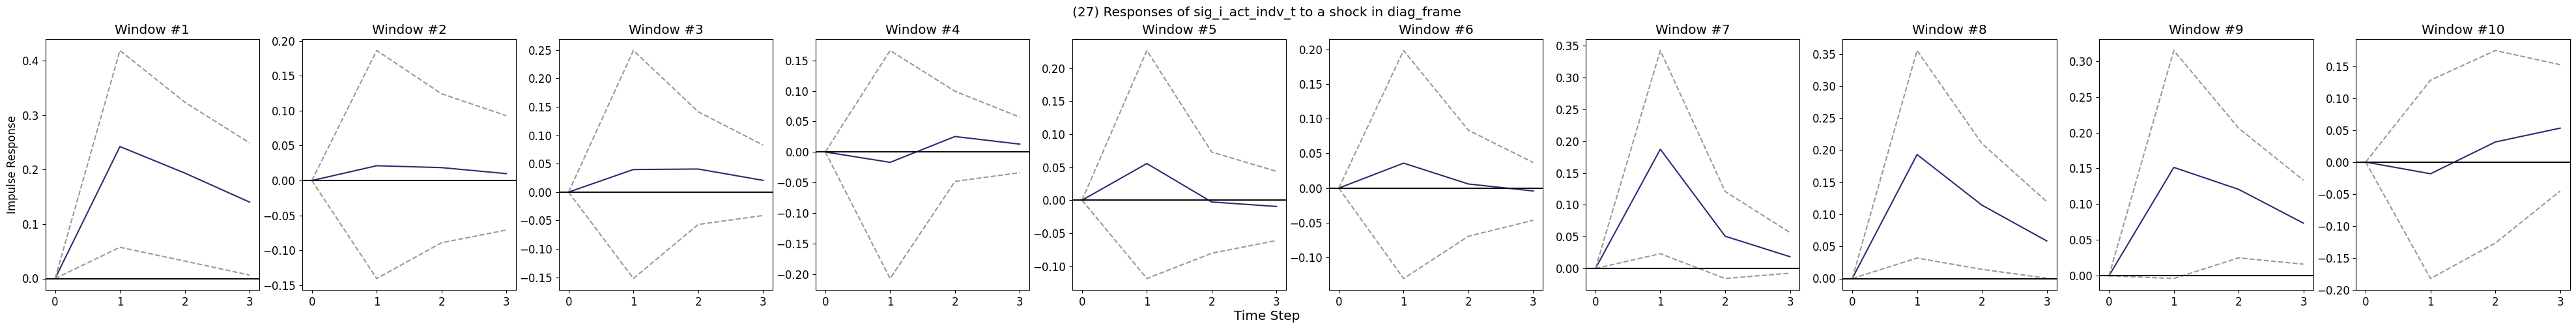

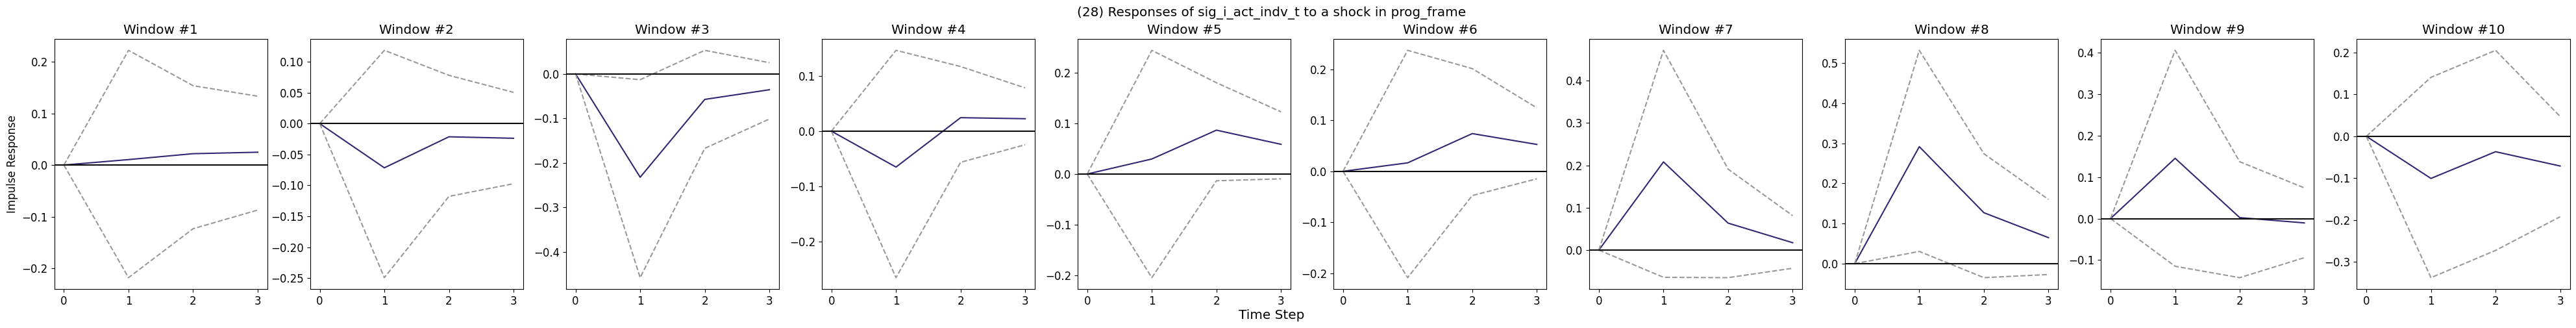

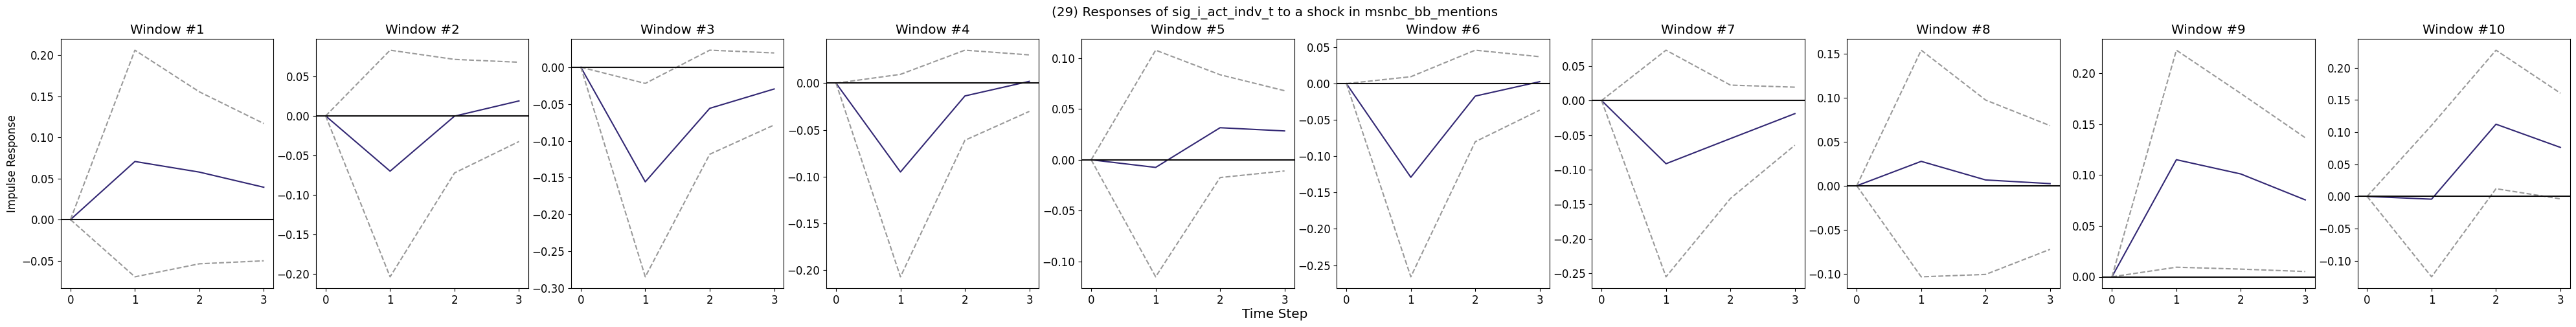

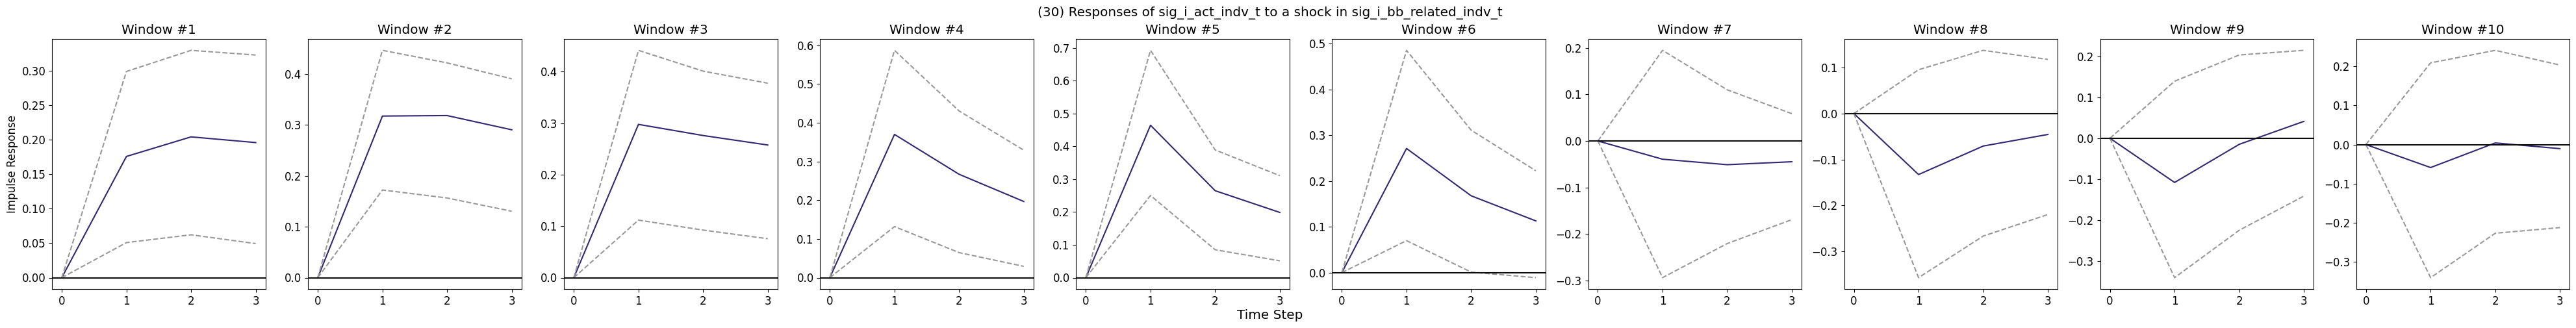

In [19]:

ctr = 0
for response in var2ix.keys():
    for impulse in var2ix.keys():
        if impulse != response:
            ctr = ctr + 1
            pt_plot_var_response(num_parts, end_vars, impulse, response, resps_dat, ctr, h_ahead=h_ahead)
            

In [88]:
print(partition_models[3].test_causality('sig_i_act_indv_t', ['sig_i_bb_related_indv_t']).summary())

print(partition_models[9].test_causality('sig_i_act_indv_t', ['Motivational Frame']).summary())


Granger causality F-test. H_0: sig_i_bb_related_indv_t does not Granger-cause sig_i_act_indv_t. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         10.55          3.851   0.001 (1, np.int64(1020))
---------------------------------------------------------
Granger causality F-test. H_0: Motivational Frame does not Granger-cause sig_i_act_indv_t. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         3.507          3.005   0.030 (2, np.int64(978))
--------------------------------------------------------


# Notes

The effect of a 1st period shock on y can be said to be strictly exogenous if we ignore contemporaneous effects 
However, the effect of of that shock beyond the first period includes systemic influences. 
Those influences, and the extent to which they account for the estimated effect in y can be unpacked using FEVD

# Analyses
**Model Equation:** 
1. Modeling Participant Behavior as Counts of BB Mentions amongst Participants
    ```py
    end_vars = [ "Motivational Frame", "Diagnostic Frame", "Prognostic Frame","msnbc_bb_mentions","sig_i_bb_related_indv_t"]
    ex_vars = ["Fox", "tod"]
    ```
    This model suggests a coupling effect on the SMO's ability to capitalize on external events and coordinate action. In later windows, the SMO appears to act in lockstep with the participants (i.e. its framing activity is closely coupled with participants' mentions of bb in the later phases). When compared to earlier windows, this coupling does not exist, at least not in the participant -> smo direction. The movement appears to become more influential in this phase as both participant and SMO utterances elicit the largest responses with respect to msnbc's coverage of breitbart. Interestingly, in this phase of the movement, the SMO's own messaging is increasingly systematic. That is, we see interesting and strong responses w.r.t to frame emissions of one type after shocks to frame emissions of other types. 

    Once prognostic frames take hold, i.e. once the SMO figures out how to spur action and discussion in the participants using prognostic frames, the movement seems to have exhausted its action repertoire. Suddently, prognostic framing no longer generates action (the SMO is no longer able to lead by action). Or its actions are no longer compelling. However, once actions loose their lustre (or the SMO just runs out of actions to take), they are able to generate participant reactions using diagnostic framing, registering the highest response amongst participants for innovations to diagnostic frame emission.

    The strong responses of prognostic frame emissions to shocks in diagnostic frames and participant bb mentions is highly suggestive of an intra-movement discourse. That is, the SMO attempts to problematize something new (diagnosing) and, subsequently, tries to propose additional action repertoires to address these issues. The participants, may be similarly engaged with SMO. We see that shocks to participant bb mentions  lead to the largest responses in SMO prgonostic framing in these later phases.

    Examining the impulse responses also reveals how the movement breaks down as their activities draw down the number of prominent breitbart advertisers. We see in the mid-range windows a decay in any mechanism that may have appeared operational in the beginning.

    Participants may have come back to sleeping giants for an outlet for their frustrations after the unite the right rally 

    To fully unpack this and lend empirical credence to statements like this, I think we need to do a DTM. This will tell us when the breitbart fodder dries up. 


### Key Citations
Helmut Lütkepohl. New Introduction to Multiple Time Series Analysis. Springer, 2005.

[Distilled explanation](https://www.r-econometrics.com/timeseries/irf/)
